# SGD or Adam: what optimizer to use?

Optimization in machine learning has two potentially conflicting goals: performing well on test set (generalization), and fitting fast on training set (optimization). While traditional optimization focus on the latter, it is generalization that matters when one deploy the model. In this paper, we explore how Adam and SGD balance this tradeoff. We focus on SGD and Adam as they are the most commonly used approach in optimizing a deep network.

<span style="color:red">The results shown in this document contain known facts (implicit regularization with SGD; early stopping related to weight decay with SGD; SGD give low norm solution). The novelty lies in our comparison of different transition schemes between Adam and SGD.</span>

To understand the properties of SGD and Adam, we use a least square regression problem as an extended example. While quadratic loss is not common in deep learning, it is locally a reasonable approximation of the loss surface.

In [1]:
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as LA
import seaborn as sns
from scipy.stats import ortho_group
import copy, tqdm

In [850]:
import os, sys
os.environ['PYTHONPATH'] = "${PYTHONPATH}:/data1/jiaxuan/2019:/data1/jiaxuan/2019/AdaBound"
sys.path.append('/data1/jiaxuan/2019')

In [ ]:
%load_ext autoreload
%autoreload 2

## Lessons from least square regression

Consider finding $\arg\min_{\theta} \mathbb{E}_{(x,t)\in D} \{x \theta - t\}$ for some distribution D. With only samples of D given, forming a design matrix $X \in \mathbb{R}^{n \times d}$ and label $y \in \mathbb{R}^n$ where $n$ is the number of data samples and $d$ is the dimension of features, we minimize the empirical risk $L(\theta) = 1/2 \Vert X \theta - y \Vert_2^2$ instead.

The loss surface of such a minimization problem is an ellipse as shown below.

![lsrloss](figures/lsr_loss.png)

(Image generated from Figure mld5 ipynb).

From this plot, it is apparent that Newton's method follows the most direct route to the solution, while Adam and SGD has two distinctive phases in the optimization process. SGD minimizes loss in large curvature direction first before it moves in the direction of small curvature. Adam exaggerates the small gradient direction and contracts the large gradient direction. 

The same observation can be generalized to all quadratic loss function. Newton's method will converge in $1$ step, SGD decreases loss in the descending order of eigenvalue directions, while Adam traverse through flat gradient regions very fast. This behavior of SGD and Newton's method is well known. We include a short proof explaining this behavior for completeness.

**proof for convergence of GD**

notation: $\theta^*$ is the optimal solution, $\eta$ is learning rate

\begin{align}
\theta_{t+1} - \theta^* &= \theta_t - \eta \nabla L(\theta_t) - \theta^*\\
&= \theta_t - \eta \nabla L(\theta_t) - (\theta^* - \eta \nabla L(\theta^*)) \quad \text{(first order optimality condition)}\\
&= (\theta_t - \theta^*) - \eta (\nabla L(\theta_t) - \nabla L(\theta^*))\\
&= (\theta_t - \theta^*) - \eta \nabla^2 L(\theta_{\zeta}) (\theta_t - \theta^*) \quad \text{(taylor's expansion with $\theta_{\zeta}$ between $\theta_t$ and $\theta^*$)}\\
&= (I - \eta \nabla^2 L(\theta_{\zeta})) (\theta_t - \theta^*)
\end{align}

It is clear that by putting constraints on eigenvalues of $\nabla^2 L(\theta_{\zeta})$ and setting $\eta$ small, gradient descent converges (SGD is similar but has an error ball term; For Newton's method the second order term actually vanishes b/c the update is $\theta_t - \nabla^2 L(\theta_{t})^{-1} L(\theta_t)$, thus progress is qudratic assuming $\theta_t$ close to solution).

**least square regression case**
\begin{align}
\theta_{t+1} - \theta^* &= (I - \eta X^\intercal X) (\theta_t - \theta^*)
\end{align}

The covariance matrix can be decomposed into $X^\intercal X = Q^\intercal \Lambda Q$, then the contraction formula becomes

$$Q(\theta_{t+1} - \theta^*) = (I - \eta \Lambda) Q (\theta_t - \theta^*)$$

Note $Q$ is a change of coordinate matrix from standard coordinate to the eigenvectors of the covariance matrix. In other words, it makes the loss ellipsoid axis aligned. Then this equation just tells us that the **error in the smallest eigenvalue direction will make the leat amount of progress** assuming $\eta$ is small (that is $1- \eta \max_i\{\lambda_i\} \geq 0$ where $\lambda_i$ is the $i^{th}$ diagonal entry of $\Lambda$). Also observe that Newton's method indeed converge in 1 step.

Although second order method such as Newton's method looks appealing, it is usually not suitable for high dimensional optimization because it has $O(d^2)$ dependence on memory and $O(d^3)$ dependence on time (matrix inversion). Furthermore, second order methods are geared towards finding zero gradient location and thus can stuck at local maximum or saddle points. Thus, we only consider Adam and SGD in this paper (approximations of gauss newton's methods are avaible, such as using idea of sketching, it's another story though).

### Convergence speed of Adam and SGD


**simulation**

With high enough condition number, we'd expect Adam to converge faster than SGD b/c Adam by design travels faster in low curvature regions. We verify this intuition by running $30$ $10d$ simulations varying condition number and model init position. We calculate the number of steps to reach within $10^{-6}$ region of the true solution. To give SGD a slight advantage, we use its optimal learning rate $\frac{2}{\lambda_\min + \lambda_\max}$, while gird search a suitable learning rate for Adam and compares the fastest learning rate. 

The data generation process is simple: we generate random orthonormal matrices $Q$, generate diagonal matrix $\Lambda$ given the condition number $\kappa=\lambda_\max / \lambda_\min$ (keep largest eigenvalue as $100$, linearly interpolate other values), and then run optimization procedure on $\theta^\intercal Q^\intercal \Lambda Q \theta$ starting from a uniformly randomly sampled point in $[2, 10]^d$. Although we use $0$ as the solution for each generated problem, the setting is general enough because both SGD and Adam is invariant to shift in coordinate (SGD is also invariant to rotation of the axis, whereas Adam is not).


In [999]:
from lib import optimizer as optimizers
from lib.utils import OptRecorder

class OptPath():
    def __init__(self, max_iter=1000, tol=1e-6):
        self.max_iter = max_iter
        self.tol = tol
        
    def get_path(self, criteria, x0, lr=1e-3, opt=torch.optim.SGD, sgd_adjust=False,
                 schedule=None, decay_rate=0.1, crosszero=False, record=False, **kwargs):
        self.lr = lr
        self.kwargs = kwargs
        self.schedule = schedule
        self.decay_rate = decay_rate
        self.crosszero = crosszero
        self.criteria = criteria
        self.validation_decay = schedule is not None and 0 in schedule
        
        x_path = [x0]
        x = torch.nn.Parameter(torch.from_numpy(x0).float().view(1, -1))
        optimizer = opt([x], lr=lr, **kwargs)
        self.opt = optimizer
        self.opt_recorder = OptRecorder(optimizer)
        if sgd_adjust: self.sgd_adjuster = optimizers.SGD_adjust(self.opt)
        
        if schedule is not None:
            if self.validation_decay:
                self.lr_decay = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=decay_rate, patience=10, cooldown=100)
            else:
                self.lr_decay = torch.optim.lr_scheduler.MultiStepLR(optimizer, schedule, gamma=decay_rate)
            
        for i in range(self.max_iter):
            optimizer.zero_grad()
            l = criteria(x)
            l.backward()
            if sgd_adjust: self.sgd_adjuster.step(l.data.item())
            optimizer.step()

            x_path.append(x.data.cpu().clone().numpy().ravel())
            if schedule is not None:
                if self.validation_decay:
                    self.lr_decay.step(l.data.item())
                else:
                    self.lr_decay.step()
                    
            if record:
                self.opt_recorder.record()
        
        x_path = np.vstack(x_path)
        self.x_path = x_path
        
    def get_converge_time(self, tol=None):
        if tol is None: tol = self.tol
        # definition of converge here is after certain iterations, the distance to 0 is smaller than tol
        t = len(self.x_path)
        for i, pt in enumerate(self.x_path[::-1]):
            l = np.linalg.norm(pt)
            if np.isnan(l):
                return len(self.x_path)
            if l > tol:
                return len(self.x_path) - i
        return 0
    
    def get_loss_time(self, tol=None):
        if tol is None: tol = self.tol
        t = len(self.x_path)
        for i, pt in enumerate(self.x_path[::-1]):
            l = self.criteria(torch.from_numpy(pt).view(1, -1).float()).item()
            if np.isnan(l):
                return len(self.x_path) * 2
            if l > tol:
                return len(self.x_path) - i
        return 0

def gen_loss(d=10, lambda_min=1, lambda_max=1, logscale=False):
    Q = ortho_group.rvs(d)
    if not logscale:
        Lambda = np.linspace(lambda_min, lambda_max, d)
    else:
        Lambda = np.logspace(np.log10(lambda_min), np.log10(lambda_max), d)
    
    A = torch.from_numpy(Q.T.dot(np.diag(Lambda)).dot(Q)).float()
    
    # x is n by d
    def res(x):
        return 0.5 * (x.mm(A) * x).sum(1)
    
    return res, Q, Lambda

opt_path = OptPath(max_iter=1000, tol=1e-6)

lambda_min = 1
lambda_max = 100
d = 3
x0 = np.array([5]*d)

criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max, logscale=True)
opt_path.get_path(criteria, x0, lr=1e-1, opt=torch.optim.Adam)
print('converge time:', opt_path.get_converge_time())

sgd_opt_lr = 2 / (lambda_min + lambda_max) 
opt_path.get_path(criteria, x0, lr=sgd_opt_lr, opt=torch.optim.SGD, sgd_adjust=True)
print('converge time:', opt_path.get_converge_time())


converge time: 314
converge time: 1001


In [166]:
from itertools import product
def plot_pairs(pairs, title='convergence time'):
    pairs = np.array(pairs)
    plt.scatter(pairs[:,0], pairs[:, 1], marker='x')
    plt.title(title, fontsize=15)
    plt.xlabel('Adam', fontsize=15)
    plt.ylabel('SGD', fontsize=15)
    
    l, r = plt.xlim()
    b, t = plt.ylim()
    m = np.linspace(min(b, l),max(t, r),30)
    plt.plot(m, m, '--', color='orange')










  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 1000











  3%|▎         | 1/30 [02:36<1:15:24, 156.02s/it]

chosen lr 1 times (adam, sgd): 100001 8098 last dist: 0.13261449633245004 3.112207861112594e-43











  7%|▋         | 2/30 [05:08<1:12:22, 155.08s/it]

chosen lr 1 times (adam, sgd): 100001 7987 last dist: 0.0013719941640854283 5.648658269960019e-43











 10%|█         | 3/30 [07:40<1:09:18, 154.03s/it]

chosen lr 1 times (adam, sgd): 100001 7884 last dist: 0.029151500351138462 3.3327933086708583e-43











 13%|█▎        | 4/30 [10:15<1:06:51, 154.29s/it]

chosen lr 1 times (adam, sgd): 100001 7632 last dist: 0.006377054340064446 6.64128254750475e-43











 17%|█▋        | 5/30 [12:46<1:03:54, 153.38s/it]

chosen lr 1 times (adam, sgd): 100001 7732 last dist: 0.05004289884916144 4.325951573606917e-43











 20%|██        | 6/30 [15:20<1:01:24, 153.50s/it]

chosen lr 1 times (adam, sgd): 100001 8092 last dist: 0.019517316623387918 5.5582110999918885e-43











 23%|██▎       | 7/30 [17:54<58:53, 153.63s/it]  

chosen lr 1 times (adam, sgd): 100001 8138 last dist: 0.13864343156416054 3.804467265345283e-43











 27%|██▋       | 8/30 [20:26<56:11, 153.26s/it]

chosen lr 1 times (adam, sgd): 100001 8180 last dist: 0.03730168047740347 4.5190300344100314e-43











 30%|███       | 9/30 [22:58<53:26, 152.70s/it]

chosen lr 1 times (adam, sgd): 100001 7847 last dist: 0.009204245418305331 4.021091808019363e-43











 33%|███▎      | 10/30 [25:31<50:58, 152.95s/it]

chosen lr 1 times (adam, sgd): 100001 8165 last dist: 0.008332357684196007 9.34520051939211e-43











 37%|███▋      | 11/30 [28:00<48:02, 151.70s/it]

chosen lr 1 times (adam, sgd): 100001 7665 last dist: 0.05134370023145269 5.948623390670845e-43











 40%|████      | 12/30 [30:31<45:24, 151.37s/it]

chosen lr 1 times (adam, sgd): 100001 7554 last dist: 2.9129958953021137e-06 4.090279561774875e-43











 43%|████▎     | 13/30 [33:03<42:58, 151.68s/it]

chosen lr 1 times (adam, sgd): 100001 8049 last dist: 0.0024333297867498165 2.9842064730053953e-43











 47%|████▋     | 14/30 [35:33<40:18, 151.14s/it]

chosen lr 1 times (adam, sgd): 100001 8167 last dist: 0.03109151028816672 4.313018206537271e-43











 50%|█████     | 15/30 [38:04<37:45, 151.01s/it]

chosen lr 1 times (adam, sgd): 100001 7616 last dist: 0.01247074447206652 2.891806102812803e-43











 53%|█████▎    | 16/30 [40:36<35:22, 151.59s/it]

chosen lr 1 times (adam, sgd): 100001 7958 last dist: 0.08795500483724968 6.562147698934946e-43











 57%|█████▋    | 17/30 [43:07<32:45, 151.20s/it]

chosen lr 1 times (adam, sgd): 100001 8243 last dist: 0.012315739231195404 8.052797884379943e-43











 60%|██████    | 18/30 [45:38<30:14, 151.18s/it]

chosen lr 1 times (adam, sgd): 100001 8027 last dist: 0.0007779943117354163 4.696043657010554e-43











 63%|██████▎   | 19/30 [48:11<27:48, 151.64s/it]

chosen lr 1 times (adam, sgd): 100001 7607 last dist: 0.007696587623145062 3.237545366997209e-43











 67%|██████▋   | 20/30 [50:49<25:37, 153.79s/it]

chosen lr 1 times (adam, sgd): 100001 8081 last dist: 0.008459440350351665 3.63571470668413e-43











 70%|███████   | 21/30 [53:27<23:14, 154.95s/it]

chosen lr 1 times (adam, sgd): 100001 8115 last dist: 0.600506534132558 9.02744052514199e-43











 73%|███████▎  | 22/30 [56:03<20:41, 155.15s/it]

chosen lr 1 times (adam, sgd): 100001 7144 last dist: 0.020487745058558486 5.6865617125703095e-43











 77%|███████▋  | 23/30 [58:41<18:12, 156.01s/it]

chosen lr 1 times (adam, sgd): 100001 6949 last dist: 0.022577574274720458 5.179764768934935e-43











 80%|████████  | 24/30 [1:01:19<15:40, 156.67s/it]

chosen lr 1 times (adam, sgd): 100001 8197 last dist: 0.018516921488313465 6.541212600106832e-43











 83%|████████▎ | 25/30 [1:03:56<13:04, 156.80s/it]

chosen lr 1 times (adam, sgd): 100001 7974 last dist: 0.04785925874088677 4.690813905272312e-43











 87%|████████▋ | 26/30 [1:06:33<10:27, 156.96s/it]

chosen lr 1 times (adam, sgd): 100001 7661 last dist: 0.2897084390666664 8.799161341626978e-43











 90%|█████████ | 27/30 [1:09:11<07:51, 157.19s/it]

chosen lr 0.1 times (adam, sgd): 99869 7555 last dist: 1.7554312652459315e-09 5.531296208790752e-43











 93%|█████████▎| 28/30 [1:11:50<05:15, 157.64s/it]

chosen lr 1 times (adam, sgd): 100001 7765 last dist: 0.0023168181973335527 9.732600430590049e-43











 97%|█████████▋| 29/30 [1:14:26<02:37, 157.29s/it]

chosen lr 0.01 times (adam, sgd): 99860 8042 last dist: 7.932318157816652e-10 5.585084183202273e-43











100%|██████████| 30/30 [1:17:04<00:00, 157.53s/it]

chosen lr 1 times (adam, sgd): 100001 8069 last dist: 0.0799824350182723 5.0857289470127524e-43


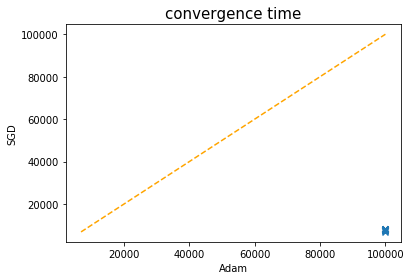

In [104]:
opt_path = OptPath(max_iter=100000, tol=1e-6)
kappas = [10**8] #[10**4, 10**8] # [1, 10, 1000] are done
lrs = [1,1e-1,1e-2]
lambda_max = 100
d = 10
n_runs = 30

for k in kappas:
    print('kappa:', k)
    lambda_min = lambda_max / k
    
    pairs = []
    for _ in tqdm.tqdm(range(n_runs)):
        # grid search for learning rate for adam
        adam_time = opt_path.max_iter + 10
        best_lr = None
        adam_last_dist = None
        for lr in lrs:
            x0 = np.random.uniform(2, 10, d)
            criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max)
            opt_path.get_path(criteria, x0, lr=lr, opt=torch.optim.Adam)
            t = opt_path.get_converge_time()
            if t < adam_time:
                best_lr = lr
                adam_last_dist = np.linalg.norm(opt_path.x_path[-1])
            adam_time = min(adam_time, t)
        
        sgd_opt_lr = 2 / (lambda_min + lambda_max) 
        opt_path.get_path(criteria, x0, lr=sgd_opt_lr, opt=torch.optim.SGD)
        sgd_time = opt_path.get_converge_time()
        sgd_last_dist = np.linalg.norm(opt_path.x_path[-1])
        
        pairs.append([adam_time, sgd_time])
        print('chosen lr {}'.format(best_lr), 'times (adam, sgd):', adam_time, sgd_time, 'last dist:', adam_last_dist, sgd_last_dist)

    plot_pairs(pairs)
    plt.savefig('figures/converge_speed_{}.png'.format(k),bbox_inches='tight')
    plt.show()


k = [1, 10, 100, 1000], d=10 note 1 and 10 need rerun for uniform random setting

![k=1](figures/converge_speed_1.png)
![k=10](figures/converge_speed_10.png)
![k=100](figures/converge_speed_100.png)
![k=1000](figures/converge_speed_1000.png)











  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 1000











  3%|▎         | 1/30 [00:07<03:48,  7.86s/it]








  7%|▋         | 2/30 [00:15<03:38,  7.81s/it]








 10%|█         | 3/30 [00:23<03:29,  7.75s/it]








 13%|█▎        | 4/30 [00:30<03:21,  7.75s/it]








 17%|█▋        | 5/30 [00:38<03:12,  7.71s/it]








 20%|██        | 6/30 [00:46<03:06,  7.76s/it]








 23%|██▎       | 7/30 [00:54<02:59,  7.79s/it]








 27%|██▋       | 8/30 [01:02<02:52,  7.85s/it]








 30%|███       | 9/30 [01:09<02:43,  7.77s/it]








 33%|███▎      | 10/30 [01:17<02:35,  7.80s/it]








 37%|███▋      | 11/30 [01:25<02:26,  7.73s/it]








 40%|████      | 12/30 [01:33<02:19,  7.73s/it]








 43%|████▎     | 13/30 [01:40<02:12,  7.79s/it]








 47%|████▋     | 14/30 [01:48<02:03,  7.73s/it]








 50%|█████     | 15/30 [01:56<01:55,  7.70s/it]








 53%|█████▎    | 16/30 [02:03<01:47,  7.71s/it]








 57%|█████▋    | 17/30 [02:11<01:41,  7.80s/it]








 60%|██████    | 18/30 [02:20<01:34,  7.90s/it]


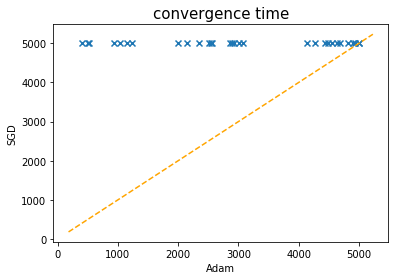

In [112]:
opt_path = OptPath(max_iter=5000, tol=1e-6)
kappas = [1000] #[10**4, 10**8] # [1, 10, 1000] are done
lrs = [1,1e-1,1e-2]
lambda_max = 100
d = 2
n_runs = 30

for k in kappas:
    print('kappa:', k)
    lambda_min = lambda_max / k
    
    pairs = []
    for _ in tqdm.tqdm(range(n_runs)):
        # grid search for learning rate for adam
        adam_time = opt_path.max_iter + 10
        best_lr = None
        adam_last_dist = None
        for lr in lrs:
            x0 = np.random.uniform(2, 10, d)
            criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max)
            opt_path.get_path(criteria, x0, lr=lr, opt=torch.optim.Adam)
            t = opt_path.get_converge_time()
            if t < adam_time:
                best_lr = lr
                adam_last_dist = np.linalg.norm(opt_path.x_path[-1])
            adam_time = min(adam_time, t)
        
        sgd_opt_lr = 2 / (lambda_min + lambda_max) 
        opt_path.get_path(criteria, x0, lr=sgd_opt_lr, opt=torch.optim.SGD)
        sgd_time = opt_path.get_converge_time()
        sgd_last_dist = np.linalg.norm(opt_path.x_path[-1])
        
        pairs.append([adam_time, sgd_time])
        #print('chosen lr {}'.format(best_lr), 'times (adam, sgd):', adam_time, sgd_time, 'last dist:', adam_last_dist, sgd_last_dist)

    plot_pairs(pairs)
    plt.savefig('figures/converge_speed_{}_d{}.png'.format(k, d),bbox_inches='tight')
    plt.show()


k = [1, 10, 100, 1000], d=2 note k=1000 need rerun b/c it hit 5000 maximum iterations

![k=1](figures/converge_speed_1_d2.png)
![k=10](figures/converge_speed_10_d2.png)
![k=100](figures/converge_speed_100_d2.png)
![k=1000](figures/converge_speed_1000_d2.png)


From the plots, Adam converges faster than SGD in 2d setting with high condition number. however, in 10d setting, SGD converges faster than Adam. This suggest **SGD converges faster than Adam in high dimensional setting and they all have difficulty dealing with high condition number**.

**Focusing just on the loss: Adam has fast progress?**

Previously we look at the proper convergence measure and observed that Adam actually converged slower that SGD with high condition number. Here we do the same experiments, but focusing on the loss. The criteria we focous on is the first iterations the algorithm hit below $0.001$ loss and stay below the value (to prevent oscillation). As shown below, under this measure, Adam has faster progress when condition number increases.











  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 1












  3%|▎         | 1/30 [00:06<03:16,  6.78s/it]

chosen lr 1 times (adam, sgd): 150 1 last dist: 3.133398622996355e-45 2.802596928649634e-45












  7%|▋         | 2/30 [00:13<03:08,  6.75s/it]

chosen lr 1 times (adam, sgd): 149 1 last dist: 4.203895392974451e-45 1.981735293180747e-45












 10%|█         | 3/30 [00:20<03:02,  6.77s/it]

chosen lr 1 times (adam, sgd): 151 1 last dist: 2.427120136778827e-45 1.981735293180747e-45












 13%|█▎        | 4/30 [00:26<02:55,  6.75s/it]

chosen lr 1 times (adam, sgd): 153 1 last dist: 4.203895392974451e-45 2.427120136778827e-45












 17%|█▋        | 5/30 [00:33<02:48,  6.75s/it]

chosen lr 1 times (adam, sgd): 152 1 last dist: 2.427120136778827e-45 2.802596928649634e-45












 20%|██        | 6/30 [00:40<02:39,  6.65s/it]

chosen lr 1 times (adam, sgd): 153 1 last dist: 3.4324662149414583e-45 2.427120136778827e-45












 23%|██▎       | 7/30 [00:47<02:34,  6.73s/it]

chosen lr 1 times (adam, sgd): 156 1 last dist: 2.802596928649634e-45 1.401298464324817e-45












 27%|██▋       | 8/30 [00:53<02:26,  6.67s/it]

chosen lr 1 times (adam, sgd): 145 1 last dist: 3.4324662149414583e-45 2.802596928649634e-45












 30%|███       | 9/30 [01:00<02:18,  6.61s/it]

chosen lr 1 times (adam, sgd): 156 1 last dist: 4.203895392974451e-45 1.401298464324817e-45












 33%|███▎      | 10/30 [01:06<02:12,  6.63s/it]

chosen lr 1 times (adam, sgd): 155 1 last dist: 2.802596928649634e-45 1.981735293180747e-45












 37%|███▋      | 11/30 [01:13<02:05,  6.62s/it]

chosen lr 1 times (adam, sgd): 150 1 last dist: 2.427120136778827e-45 1.401298464324817e-45












 40%|████      | 12/30 [01:19<01:58,  6.59s/it]

chosen lr 1 times (adam, sgd): 151 1 last dist: 3.133398622996355e-45 1.981735293180747e-45












 43%|████▎     | 13/30 [01:26<01:53,  6.65s/it]

chosen lr 1 times (adam, sgd): 155 1 last dist: 2.427120136778827e-45 1.401298464324817e-45












 47%|████▋     | 14/30 [01:33<01:46,  6.65s/it]

chosen lr 1 times (adam, sgd): 149 1 last dist: 3.7074872491801824e-45 0.0












 50%|█████     | 15/30 [01:39<01:38,  6.56s/it]

chosen lr 1 times (adam, sgd): 143 1 last dist: 3.7074872491801824e-45 2.427120136778827e-45












 53%|█████▎    | 16/30 [01:46<01:32,  6.63s/it]

chosen lr 1 times (adam, sgd): 154 1 last dist: 3.7074872491801824e-45 0.0












 57%|█████▋    | 17/30 [01:53<01:26,  6.67s/it]

chosen lr 1 times (adam, sgd): 152 1 last dist: 2.427120136778827e-45 1.981735293180747e-45












 60%|██████    | 18/30 [02:00<01:20,  6.74s/it]

chosen lr 1 times (adam, sgd): 150 1 last dist: 2.802596928649634e-45 2.427120136778827e-45












 63%|██████▎   | 19/30 [02:06<01:14,  6.73s/it]

chosen lr 1 times (adam, sgd): 153 1 last dist: 3.4324662149414583e-45 1.981735293180747e-45












 67%|██████▋   | 20/30 [02:13<01:07,  6.71s/it]

chosen lr 1 times (adam, sgd): 149 1 last dist: 3.963470586361494e-45 1.981735293180747e-45












 70%|███████   | 21/30 [02:20<01:00,  6.67s/it]

chosen lr 1 times (adam, sgd): 155 1 last dist: 0.0 1.981735293180747e-45












 73%|███████▎  | 22/30 [02:26<00:52,  6.55s/it]

chosen lr 1 times (adam, sgd): 149 1 last dist: 4.203895392974451e-45 0.0












 77%|███████▋  | 23/30 [02:32<00:45,  6.54s/it]

chosen lr 1 times (adam, sgd): 151 1 last dist: 3.133398622996355e-45 1.981735293180747e-45












 80%|████████  | 24/30 [02:39<00:39,  6.59s/it]

chosen lr 1 times (adam, sgd): 157 1 last dist: 2.427120136778827e-45 1.401298464324817e-45












 83%|████████▎ | 25/30 [02:46<00:33,  6.63s/it]

chosen lr 1 times (adam, sgd): 157 1 last dist: 2.802596928649634e-45 2.427120136778827e-45












 87%|████████▋ | 26/30 [02:52<00:26,  6.62s/it]

chosen lr 1 times (adam, sgd): 149 1 last dist: 5.605193857299268e-45 1.401298464324817e-45












 90%|█████████ | 27/30 [02:59<00:19,  6.57s/it]

chosen lr 1 times (adam, sgd): 152 1 last dist: 3.4324662149414583e-45 1.981735293180747e-45












 93%|█████████▎| 28/30 [03:06<00:13,  6.64s/it]

chosen lr 1 times (adam, sgd): 156 1 last dist: 4.64758122546664e-45 1.981735293180747e-45












 97%|█████████▋| 29/30 [03:12<00:06,  6.67s/it]

chosen lr 1 times (adam, sgd): 151 1 last dist: 2.802596928649634e-45 2.427120136778827e-45












100%|██████████| 30/30 [03:19<00:00,  6.75s/it]

chosen lr 1 times (adam, sgd): 157 1 last dist: 4.203895392974451e-45 2.427120136778827e-45


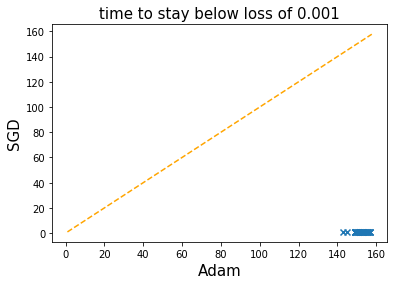











  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 10












  3%|▎         | 1/30 [00:06<03:05,  6.40s/it]

chosen lr 1 times (adam, sgd): 149 31 last dist: 2.0955551333182765e-37 0.0












  7%|▋         | 2/30 [00:13<03:01,  6.49s/it]

chosen lr 1 times (adam, sgd): 141 25 last dist: 6.26679724599271e-45 3.4324662149414583e-45












 10%|█         | 3/30 [00:19<02:55,  6.49s/it]

chosen lr 0.1 times (adam, sgd): 624 37 last dist: 1.189041175908448e-44 2.802596928649634e-45












 13%|█▎        | 4/30 [00:26<02:48,  6.49s/it]

chosen lr 1 times (adam, sgd): 146 33 last dist: 2.802596928649634e-45 3.963470586361494e-45












 17%|█▋        | 5/30 [00:32<02:42,  6.48s/it]

chosen lr 0.1 times (adam, sgd): 548 35 last dist: 1.3440782697557323e-44 3.133398622996355e-45












 20%|██        | 6/30 [00:38<02:33,  6.39s/it]

chosen lr 0.1 times (adam, sgd): 2792 28 last dist: 4.239321734638753e-08 5.243178750115932e-45












 23%|██▎       | 7/30 [00:45<02:28,  6.47s/it]

chosen lr 0.1 times (adam, sgd): 715 33 last dist: 6.320833840305073e-40 4.203895392974451e-45












 27%|██▋       | 8/30 [00:52<02:23,  6.52s/it]

chosen lr 1 times (adam, sgd): 146 38 last dist: 1.4361282975534428e-41 7.281360410336481e-45












 30%|███       | 9/30 [00:58<02:16,  6.51s/it]

chosen lr 0.1 times (adam, sgd): 550 30 last dist: 4.203895392974451e-45 3.963470586361494e-45












 33%|███▎      | 10/30 [01:04<02:07,  6.40s/it]

chosen lr 0.1 times (adam, sgd): 502 36 last dist: 1.085441123079209e-44 3.133398622996355e-45












 37%|███▋      | 11/30 [01:10<02:01,  6.37s/it]

chosen lr 0.1 times (adam, sgd): 465 39 last dist: 7.675227787080506e-45 2.802596928649634e-45












 40%|████      | 12/30 [01:17<01:54,  6.33s/it]

chosen lr 0.01 times (adam, sgd): 2552 35 last dist: 0.002632414152536405 3.4324662149414583e-45












 43%|████▎     | 13/30 [01:23<01:46,  6.26s/it]

chosen lr 0.1 times (adam, sgd): 534 35 last dist: 1.805446775996925e-44 1.401298464324817e-45












 47%|████▋     | 14/30 [01:29<01:40,  6.28s/it]

chosen lr 0.1 times (adam, sgd): 645 37 last dist: 1.0486357500231864e-44 8.862589657925252e-45












 50%|█████     | 15/30 [01:36<01:34,  6.32s/it]

chosen lr 0.1 times (adam, sgd): 384 29 last dist: 6.864932429882917e-45 4.431294828962626e-45












 53%|█████▎    | 16/30 [01:42<01:29,  6.39s/it]

chosen lr 0.1 times (adam, sgd): 552 34 last dist: 5.427205615396045e-45 2.427120136778827e-45












 57%|█████▋    | 17/30 [01:49<01:24,  6.51s/it]

chosen lr 1 times (adam, sgd): 152 33 last dist: 6.767154513468755e-43 2.802596928649634e-45












 60%|██████    | 18/30 [01:56<01:18,  6.55s/it]

chosen lr 1 times (adam, sgd): 143 40 last dist: 2.0258336893706008e-44 3.133398622996355e-45












 63%|██████▎   | 19/30 [02:02<01:13,  6.67s/it]

chosen lr 1 times (adam, sgd): 152 41 last dist: 9.609951738435813e-20 0.0












 67%|██████▋   | 20/30 [02:09<01:05,  6.56s/it]

chosen lr 1 times (adam, sgd): 153 39 last dist: 1.3367535380048083e-44 0.0












 70%|███████   | 21/30 [02:15<00:59,  6.57s/it]

chosen lr 1 times (adam, sgd): 157 35 last dist: 1.401298464324817e-45 3.133398622996355e-45












 73%|███████▎  | 22/30 [02:22<00:52,  6.58s/it]

chosen lr 1 times (adam, sgd): 2760 29 last dist: 2.0008619371329134e-08 3.7074872491801824e-45












 77%|███████▋  | 23/30 [02:28<00:45,  6.47s/it]

chosen lr 0.1 times (adam, sgd): 416 32 last dist: 4.749631558480499e-36 3.133398622996355e-45












 80%|████████  | 24/30 [02:35<00:38,  6.46s/it]

chosen lr 0.1 times (adam, sgd): 387 26 last dist: 8.751106104867232e-45 3.963470586361494e-45












 83%|████████▎ | 25/30 [02:41<00:32,  6.47s/it]

chosen lr 1 times (adam, sgd): 146 39 last dist: 7.802099651356153e-45 0.0












 87%|████████▋ | 26/30 [02:48<00:25,  6.46s/it]

chosen lr 0.1 times (adam, sgd): 585 36 last dist: 1.197269932749894e-44 1.2135600683894136e-44












 90%|█████████ | 27/30 [02:54<00:19,  6.56s/it]

chosen lr 1 times (adam, sgd): 149 36 last dist: 7.281360410336481e-45 3.7074872491801824e-45












 93%|█████████▎| 28/30 [03:01<00:13,  6.54s/it]

chosen lr 0.1 times (adam, sgd): 342 27 last dist: 4.203895392974451e-45 3.133398622996355e-45












 97%|█████████▋| 29/30 [03:07<00:06,  6.57s/it]

chosen lr 0.1 times (adam, sgd): 240 36 last dist: 3.133398622996355e-45 3.7074872491801824e-45












100%|██████████| 30/30 [03:14<00:00,  6.50s/it]

chosen lr 0.1 times (adam, sgd): 504 37 last dist: 1.832435518719184e-44 2.802596928649634e-45


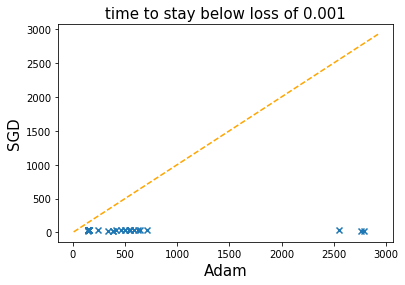











  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 100












  3%|▎         | 1/30 [00:06<03:15,  6.75s/it]

chosen lr 0.1 times (adam, sgd): 1135 349 last dist: 9.609203476981183e-16 7.786915476682111e-26












  7%|▋         | 2/30 [00:12<03:04,  6.58s/it]

chosen lr 0.1 times (adam, sgd): 620 380 last dist: 6.864932429882917e-45 7.867825133901713e-26












 10%|█         | 3/30 [00:18<02:53,  6.41s/it]

chosen lr 0.1 times (adam, sgd): 2095 378 last dist: 0.0005233447674362842 1.040100545510039e-25












 13%|█▎        | 4/30 [00:25<02:47,  6.45s/it]

chosen lr 1 times (adam, sgd): 331 358 last dist: 1.981735293180747e-45 5.183444882110181e-26












 17%|█▋        | 5/30 [00:31<02:41,  6.44s/it]

chosen lr 0.1 times (adam, sgd): 1290 314 last dist: 1.921689963232206e-10 9.011193946386231e-26












 20%|██        | 6/30 [00:37<02:31,  6.31s/it]

chosen lr 0.1 times (adam, sgd): 2167 380 last dist: 0.00036902206252645823 9.023185649866161e-26












 23%|██▎       | 7/30 [00:44<02:29,  6.49s/it]

chosen lr 1 times (adam, sgd): 230 315 last dist: 6.572672401285492e-45 2.8930195636927814e-26












 27%|██▋       | 8/30 [00:51<02:24,  6.56s/it]

chosen lr 1 times (adam, sgd): 242 297 last dist: 8.972688160795666e-45 9.3110923490187e-26












 30%|███       | 9/30 [00:57<02:15,  6.47s/it]

chosen lr 0.1 times (adam, sgd): 1456 369 last dist: 6.641702454945659e-08 6.635726312955122e-26












 33%|███▎      | 10/30 [01:04<02:08,  6.40s/it]

chosen lr 1 times (adam, sgd): 189 356 last dist: 1.2216236791461228e-44 7.222411860402282e-26












 37%|███▋      | 11/30 [01:10<01:59,  6.31s/it]

chosen lr 0.1 times (adam, sgd): 2836 359 last dist: 1.014665190449719e-06 1.4212885557401182e-25












 40%|████      | 12/30 [01:16<01:54,  6.38s/it]

chosen lr 0.1 times (adam, sgd): 1245 223 last dist: 9.57013831093027e-10 2.1950752809369937e-26












 43%|████▎     | 13/30 [01:22<01:47,  6.31s/it]

chosen lr 0.1 times (adam, sgd): 2776 387 last dist: 8.643413575352655e-08 1.0168017407829277e-25












 47%|████▋     | 14/30 [01:29<01:40,  6.29s/it]

chosen lr 0.1 times (adam, sgd): 1573 312 last dist: 4.601247025636565e-07 3.627255432728242e-26












 50%|█████     | 15/30 [01:35<01:35,  6.35s/it]

chosen lr 1 times (adam, sgd): 223 332 last dist: 5.427205615396045e-45 3.672081545098716e-26












 53%|█████▎    | 16/30 [01:41<01:28,  6.34s/it]

chosen lr 1 times (adam, sgd): 2821 381 last dist: 4.930815951790884e-07 9.512960966218188e-26












 57%|█████▋    | 17/30 [01:48<01:22,  6.37s/it]

chosen lr 1 times (adam, sgd): 149 351 last dist: 5.0524534653520735e-45 1.0994426502376578e-25












 60%|██████    | 18/30 [01:54<01:15,  6.31s/it]

chosen lr 0.1 times (adam, sgd): 1640 326 last dist: 1.6239729293693545e-05 6.697092140330951e-26












 63%|██████▎   | 19/30 [02:01<01:10,  6.40s/it]

chosen lr 1 times (adam, sgd): 215 355 last dist: 8.049846814811446e-45 1.5881268828131119e-25












 67%|██████▋   | 20/30 [02:07<01:04,  6.44s/it]

chosen lr 1 times (adam, sgd): 152 390 last dist: 5.605193857299268e-45 1.0278780193787004e-25












 70%|███████   | 21/30 [02:13<00:57,  6.41s/it]

chosen lr 0.1 times (adam, sgd): 2132 343 last dist: 0.00040101373194853166 1.509707584896179e-25












 73%|███████▎  | 22/30 [02:20<00:51,  6.41s/it]

chosen lr 0.1 times (adam, sgd): 1445 375 last dist: 4.944575521908336e-08 7.706292726059343e-26












 77%|███████▋  | 23/30 [02:26<00:44,  6.40s/it]

chosen lr 0.1 times (adam, sgd): 1219 391 last dist: 1.895421893224544e-09 9.621795666297696e-26












 80%|████████  | 24/30 [02:33<00:38,  6.44s/it]

chosen lr 0.1 times (adam, sgd): 1316 307 last dist: 1.1112835555157367e-10 2.0076453844079017e-26












 83%|████████▎ | 25/30 [02:39<00:31,  6.39s/it]

chosen lr 0.1 times (adam, sgd): 1386 342 last dist: 1.6302943495767394e-07 6.819847686344791e-26












 87%|████████▋ | 26/30 [02:46<00:25,  6.42s/it]

chosen lr 1 times (adam, sgd): 234 272 last dist: 0.00160884231892159 4.8776500607872285e-26












 90%|█████████ | 27/30 [02:52<00:19,  6.38s/it]

chosen lr 0.1 times (adam, sgd): 1579 337 last dist: 1.8605373903810396e-06 5.71269833356697e-26












 93%|█████████▎| 28/30 [02:58<00:12,  6.39s/it]

chosen lr 0.1 times (adam, sgd): 1421 348 last dist: 1.5669784391640033e-10 4.08779371469303e-26












 97%|█████████▋| 29/30 [03:05<00:06,  6.39s/it]

chosen lr 0.1 times (adam, sgd): 1255 348 last dist: 3.800388689432658e-08 1.0202156590547177e-25












100%|██████████| 30/30 [03:11<00:00,  6.31s/it]

chosen lr 0.1 times (adam, sgd): 1408 362 last dist: 6.758591454758211e-09 6.548012073109572e-26


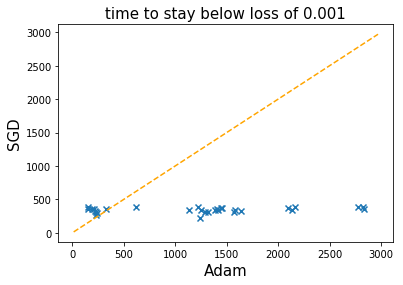











  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 1000












  3%|▎         | 1/30 [00:05<02:52,  5.96s/it]

chosen lr 1 times (adam, sgd): 2540 3001 last dist: 9.079564397118909e-12 0.026129756482208635












  7%|▋         | 2/30 [00:12<02:47,  6.00s/it]

chosen lr 1 times (adam, sgd): 529 3001 last dist: 6.714822079011227e-12 0.013084448749593008












 10%|█         | 3/30 [00:18<02:41,  5.99s/it]

chosen lr 1 times (adam, sgd): 2762 3001 last dist: 2.168754469365767e-08 0.017437080894499392












 13%|█▎        | 4/30 [00:23<02:35,  5.97s/it]

chosen lr 1 times (adam, sgd): 670 3001 last dist: 1.6489021216708338e-10 0.030532782040725077












 17%|█▋        | 5/30 [00:29<02:29,  5.98s/it]

chosen lr 10 times (adam, sgd): 2952 2810 last dist: 0.0004563198527872556 0.031760796966914764












 20%|██        | 6/30 [00:35<02:23,  5.97s/it]

chosen lr 1 times (adam, sgd): 2700 3001 last dist: 6.958752952835851e-09 0.02139131780366777












 23%|██▎       | 7/30 [00:41<02:17,  5.98s/it]

chosen lr 1 times (adam, sgd): 2932 3001 last dist: 0.0001560287351434662 0.01280924377827395












 27%|██▋       | 8/30 [00:48<02:13,  6.05s/it]

chosen lr 1 times (adam, sgd): 814 3001 last dist: 3.115179458650041e-17 0.02037861055689127












 30%|███       | 9/30 [00:53<02:05,  5.96s/it]

chosen lr 10 times (adam, sgd): 3001 3001 last dist: 0.2501148889112015 0.009401093692327377












 33%|███▎      | 10/30 [00:59<01:59,  5.98s/it]

chosen lr 1 times (adam, sgd): 504 2586 last dist: 7.64173483404576e-22 0.01477481240479618












 37%|███▋      | 11/30 [01:05<01:53,  5.99s/it]

chosen lr 1 times (adam, sgd): 2994 3001 last dist: 0.0017301266413053296 0.02855077455112557












 40%|████      | 12/30 [01:11<01:47,  5.95s/it]

chosen lr 0.1 times (adam, sgd): 1693 2487 last dist: 0.023575313153868883 0.011120574161869476












 43%|████▎     | 13/30 [01:17<01:40,  5.92s/it]

chosen lr 1 times (adam, sgd): 2839 3001 last dist: 8.362703544120355e-07 0.010326583564187928












 47%|████▋     | 14/30 [01:23<01:34,  5.92s/it]

chosen lr 1 times (adam, sgd): 1087 3001 last dist: 1.6393836474003762e-10 0.034464209214511654












 50%|█████     | 15/30 [01:29<01:29,  5.97s/it]

chosen lr 1 times (adam, sgd): 948 2609 last dist: 5.43200015840781e-13 0.006810323474188405












 53%|█████▎    | 16/30 [01:35<01:24,  6.04s/it]

chosen lr 1 times (adam, sgd): 2664 3001 last dist: 4.383016725752904e-09 0.007997772374861016












 57%|█████▋    | 17/30 [01:41<01:18,  6.02s/it]

chosen lr 0.1 times (adam, sgd): 2992 3001 last dist: 0.14071088638380197 0.0400350373944079












 60%|██████    | 18/30 [01:47<01:12,  6.06s/it]

chosen lr 1 times (adam, sgd): 334 3001 last dist: 3.898827144268535e-11 0.010163522220050153












 63%|██████▎   | 19/30 [01:53<01:05,  5.96s/it]

chosen lr 1 times (adam, sgd): 2604 3001 last dist: 7.790404751231209e-12 0.027208575084938784












 67%|██████▋   | 20/30 [01:59<00:59,  5.99s/it]

chosen lr 1 times (adam, sgd): 2920 3001 last dist: 8.206692216165686e-05 0.03160083655281718












 70%|███████   | 21/30 [02:05<00:54,  6.04s/it]

chosen lr 10 times (adam, sgd): 3001 1999 last dist: 0.20907917384655506 0.014480028834529382












 73%|███████▎  | 22/30 [02:11<00:48,  6.02s/it]

chosen lr 10 times (adam, sgd): 3001 2412 last dist: 0.02307348277656303 0.0018066696632779889












 77%|███████▋  | 23/30 [02:17<00:41,  5.89s/it]

chosen lr 1 times (adam, sgd): 2682 3001 last dist: 1.1915143857360514e-08 0.01904298764903405












 80%|████████  | 24/30 [02:23<00:35,  5.99s/it]

chosen lr 0.1 times (adam, sgd): 585 3001 last dist: 0.03276468783116514 0.014474160359089152












 83%|████████▎ | 25/30 [02:29<00:30,  6.02s/it]

chosen lr 1 times (adam, sgd): 475 3001 last dist: 8.649563993996495e-41 0.008007723396264843












 87%|████████▋ | 26/30 [02:35<00:23,  5.98s/it]

chosen lr 10 times (adam, sgd): 3001 2468 last dist: 1.154390272457692 0.017168759222729427












 90%|█████████ | 27/30 [02:41<00:17,  5.90s/it]

chosen lr 0.1 times (adam, sgd): 2947 2114 last dist: 0.13427848423312283 0.022904746339793725












 93%|█████████▎| 28/30 [02:47<00:11,  5.91s/it]

chosen lr 1 times (adam, sgd): 2952 3001 last dist: 0.0001626365101673593 0.01937055802194079












 97%|█████████▋| 29/30 [02:53<00:05,  5.89s/it]

chosen lr 1 times (adam, sgd): 2727 3001 last dist: 9.744177701239037e-09 0.027850123981410596












100%|██████████| 30/30 [02:59<00:00,  5.89s/it]

chosen lr 0.1 times (adam, sgd): 2810 3001 last dist: 0.021596688937636443 0.01145520050919608


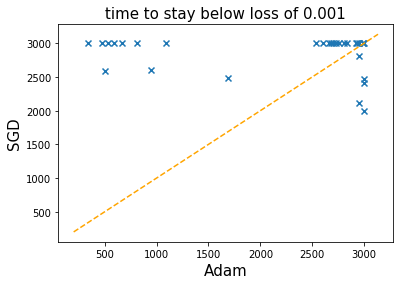











  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 10000












  3%|▎         | 1/30 [00:05<02:47,  5.77s/it]

chosen lr 1 times (adam, sgd): 2926 3001 last dist: 0.2879239135133485 2.2171313973375737












  7%|▋         | 2/30 [00:11<02:43,  5.83s/it]

chosen lr 0.1 times (adam, sgd): 647 3001 last dist: 0.2207571950287628 6.574610563964533












 10%|█         | 3/30 [00:17<02:40,  5.94s/it]

chosen lr 10 times (adam, sgd): 3001 3001 last dist: 3.4796643263091784 2.9231005476948604












 13%|█▎        | 4/30 [00:23<02:32,  5.85s/it]

chosen lr 1 times (adam, sgd): 2963 3001 last dist: 0.023217320374087972 2.975623827770631












 17%|█▋        | 5/30 [00:29<02:27,  5.91s/it]

chosen lr 1 times (adam, sgd): 2783 3001 last dist: 0.03872202825498428 1.134521901796762












 20%|██        | 6/30 [00:35<02:22,  5.92s/it]

chosen lr 10 times (adam, sgd): 3001 3001 last dist: 0.012003562009170058 3.969244116883663












 23%|██▎       | 7/30 [00:41<02:17,  5.96s/it]

chosen lr 1 times (adam, sgd): 1931 3001 last dist: 0.07221682508616874 3.310198980079499












 27%|██▋       | 8/30 [00:47<02:10,  5.94s/it]

chosen lr 10 times (adam, sgd): 3001 3001 last dist: 0.012332750343695496 7.2721160768562525












 30%|███       | 9/30 [00:53<02:06,  6.05s/it]

chosen lr 1 times (adam, sgd): 2786 3001 last dist: 0.17300515313247466 3.0371315569319823












 33%|███▎      | 10/30 [00:59<02:00,  6.01s/it]

chosen lr 1 times (adam, sgd): 2855 3001 last dist: 0.06052910899126788 4.4099793398350915












 37%|███▋      | 11/30 [01:05<01:53,  5.96s/it]

chosen lr 1 times (adam, sgd): 2999 3001 last dist: 0.07060231834165656 7.749327801796514












 40%|████      | 12/30 [01:11<01:47,  5.96s/it]

chosen lr 1 times (adam, sgd): 2785 3001 last dist: 0.06947650902740994 1.7776251843793898












 43%|████▎     | 13/30 [01:17<01:42,  6.03s/it]

chosen lr 0.1 times (adam, sgd): 656 3001 last dist: 0.30976750557079247 7.408623112163249












 47%|████▋     | 14/30 [01:23<01:36,  6.00s/it]

chosen lr 1 times (adam, sgd): 2744 3001 last dist: 0.2343361339989412 6.712497754825197












 50%|█████     | 15/30 [01:29<01:30,  6.02s/it]

chosen lr 10 times (adam, sgd): 3001 3001 last dist: 1.9925624929691597 5.156990037394909












 53%|█████▎    | 16/30 [01:35<01:23,  5.99s/it]

chosen lr 0.1 times (adam, sgd): 448 3001 last dist: 0.2887970509747179 6.064718826681083












 57%|█████▋    | 17/30 [01:41<01:18,  6.02s/it]

chosen lr 10 times (adam, sgd): 3001 3001 last dist: 0.701149580091481 1.4490303734526635












 60%|██████    | 18/30 [01:47<01:11,  5.95s/it]

chosen lr 1 times (adam, sgd): 2944 3001 last dist: 0.008712079687727073 6.243646342579019












 63%|██████▎   | 19/30 [01:53<01:05,  6.00s/it]

chosen lr 1 times (adam, sgd): 2883 3001 last dist: 0.017680922230015536 4.316876211596961












 67%|██████▋   | 20/30 [01:59<00:59,  5.92s/it]

chosen lr 1 times (adam, sgd): 2086 3001 last dist: 0.1033154363298199 4.330934611403262












 70%|███████   | 21/30 [02:05<00:53,  5.92s/it]

chosen lr 1 times (adam, sgd): 2854 3001 last dist: 0.06318349450396862 6.821838407554478












 73%|███████▎  | 22/30 [02:11<00:47,  5.92s/it]

chosen lr 1 times (adam, sgd): 2467 3001 last dist: 0.27257251119776493 7.738197157535542












 77%|███████▋  | 23/30 [02:17<00:41,  5.93s/it]

chosen lr 1 times (adam, sgd): 3000 3001 last dist: 0.010344371328029364 9.51101815683754












 80%|████████  | 24/30 [02:23<00:35,  5.95s/it]

chosen lr 10 times (adam, sgd): 3001 3001 last dist: 0.500815555954077 3.0741837600824464












 83%|████████▎ | 25/30 [02:29<00:29,  5.94s/it]

chosen lr 1 times (adam, sgd): 1937 3001 last dist: 0.10468696468238964 3.644913348430761












 87%|████████▋ | 26/30 [02:35<00:23,  5.95s/it]

chosen lr 1 times (adam, sgd): 2809 3001 last dist: 0.13931435350797308 2.1171692719334896












 90%|█████████ | 27/30 [02:41<00:18,  6.00s/it]

chosen lr 1 times (adam, sgd): 2788 3001 last dist: 0.11916800450278338 3.539626600801634












 93%|█████████▎| 28/30 [02:47<00:11,  5.99s/it]

chosen lr 0.01 times (adam, sgd): 2827 3001 last dist: 0.19148088917192777 4.700599767025354












 97%|█████████▋| 29/30 [02:53<00:06,  6.02s/it]

chosen lr 10 times (adam, sgd): 2984 3001 last dist: 0.0028768100794826852 3.691731183508566












100%|██████████| 30/30 [02:59<00:00,  6.06s/it]

chosen lr 0.1 times (adam, sgd): 193 3001 last dist: 0.09267040728735547 2.853391448833286


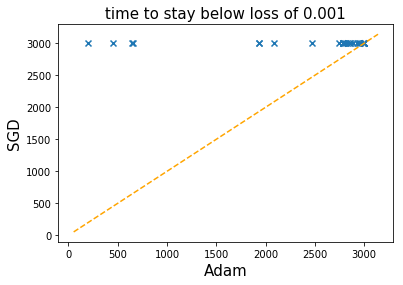











  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 100000000












  3%|▎         | 1/30 [00:06<03:01,  6.26s/it]

chosen lr 0.1 times (adam, sgd): 527 3001 last dist: 2.123124668652303 8.567693018975552












  7%|▋         | 2/30 [00:12<02:55,  6.25s/it]

chosen lr 0.1 times (adam, sgd): 571 3001 last dist: 3.5068695691638077 2.563010203788346












 10%|█         | 3/30 [00:18<02:46,  6.16s/it]

chosen lr 0.1 times (adam, sgd): 325 3001 last dist: 0.4600660879280112 6.374413098452582












 13%|█▎        | 4/30 [00:24<02:38,  6.11s/it]

chosen lr 0.1 times (adam, sgd): 372 3001 last dist: 0.10503050324912398 8.187394476240996












 17%|█▋        | 5/30 [00:30<02:28,  5.95s/it]

chosen lr 0.1 times (adam, sgd): 542 3001 last dist: 0.45589767551095994 14.142132550632873












 20%|██        | 6/30 [00:36<02:24,  6.04s/it]

chosen lr 1 times (adam, sgd): 143 3001 last dist: 3.9985401844938644 13.09756624417114












 23%|██▎       | 7/30 [00:42<02:18,  6.04s/it]

chosen lr 0.1 times (adam, sgd): 506 3001 last dist: 0.685377008370717 10.595184754749157












 27%|██▋       | 8/30 [00:48<02:12,  6.03s/it]

chosen lr 0.1 times (adam, sgd): 627 3001 last dist: 3.99360387857242 9.075036493312671












 30%|███       | 9/30 [00:54<02:09,  6.15s/it]

chosen lr 0.1 times (adam, sgd): 560 3001 last dist: 1.7589984996896835 9.082622610579753












 33%|███▎      | 10/30 [01:00<02:02,  6.14s/it]

chosen lr 0.1 times (adam, sgd): 347 3001 last dist: 3.513442908695259 5.7312035147713605












 37%|███▋      | 11/30 [01:06<01:55,  6.08s/it]

chosen lr 0.1 times (adam, sgd): 309 3001 last dist: 4.55688420322977 16.13751868649617












 40%|████      | 12/30 [01:12<01:49,  6.09s/it]

chosen lr 0.1 times (adam, sgd): 450 3001 last dist: 0.24584391238483116 6.656161769730638












 43%|████▎     | 13/30 [01:19<01:44,  6.14s/it]

chosen lr 0.1 times (adam, sgd): 480 3001 last dist: 10.777818686855243 7.240442314311637












 47%|████▋     | 14/30 [01:25<01:37,  6.07s/it]

chosen lr 0.1 times (adam, sgd): 360 3001 last dist: 1.2073117857683815 10.015860029142813












 50%|█████     | 15/30 [01:31<01:32,  6.17s/it]

chosen lr 1 times (adam, sgd): 150 3001 last dist: 4.622396306510536 4.406638012687976












 53%|█████▎    | 16/30 [01:37<01:25,  6.14s/it]

chosen lr 0.1 times (adam, sgd): 273 3001 last dist: 1.0226479592356061 13.36004435021797












 57%|█████▋    | 17/30 [01:43<01:20,  6.15s/it]

chosen lr 0.1 times (adam, sgd): 256 3001 last dist: 7.0155059646771605 9.392756420038411












 60%|██████    | 18/30 [01:49<01:12,  6.06s/it]

chosen lr 0.1 times (adam, sgd): 370 3001 last dist: 6.095006574816799 11.446960077783354












 63%|██████▎   | 19/30 [01:55<01:06,  6.05s/it]

chosen lr 1 times (adam, sgd): 145 3001 last dist: 1.9525480972381712 5.761943507444069












 67%|██████▋   | 20/30 [02:01<01:00,  6.08s/it]

chosen lr 0.1 times (adam, sgd): 199 3001 last dist: 10.650729122801293 5.098924883188251












 70%|███████   | 21/30 [02:08<00:56,  6.23s/it]

chosen lr 1 times (adam, sgd): 149 3001 last dist: 11.600662691911921 10.356985958192285












 73%|███████▎  | 22/30 [02:14<00:49,  6.17s/it]

chosen lr 0.1 times (adam, sgd): 472 3001 last dist: 2.2244212990048307 10.509820782775577












 77%|███████▋  | 23/30 [02:20<00:43,  6.18s/it]

chosen lr 0.1 times (adam, sgd): 542 3001 last dist: 1.2903293910360145 4.437223037769402












 80%|████████  | 24/30 [02:26<00:36,  6.15s/it]

chosen lr 0.1 times (adam, sgd): 181 3001 last dist: 5.947327072945458 15.021424271649442












 83%|████████▎ | 25/30 [02:33<00:31,  6.25s/it]

chosen lr 0.1 times (adam, sgd): 479 3001 last dist: 0.6662692129818436 3.2475325179201304












 87%|████████▋ | 26/30 [02:39<00:24,  6.19s/it]

chosen lr 0.1 times (adam, sgd): 385 3001 last dist: 1.4255763054615478 6.481564928069893












 90%|█████████ | 27/30 [02:45<00:18,  6.19s/it]

chosen lr 0.1 times (adam, sgd): 400 3001 last dist: 6.599959591124813 7.22244232857198












 93%|█████████▎| 28/30 [02:51<00:12,  6.11s/it]

chosen lr 0.1 times (adam, sgd): 438 3001 last dist: 2.7868182998248696 6.766985586205339












 97%|█████████▋| 29/30 [02:57<00:06,  6.12s/it]

chosen lr 0.1 times (adam, sgd): 602 3001 last dist: 12.065795289945653 11.01362486951748












100%|██████████| 30/30 [03:03<00:00,  6.12s/it]

chosen lr 0.1 times (adam, sgd): 477 3001 last dist: 4.082029556413917 5.368287511711574


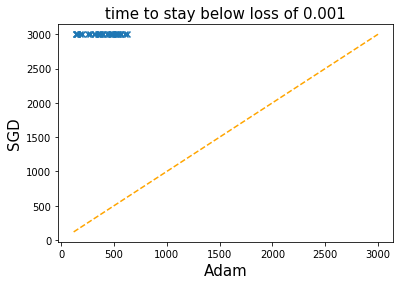

In [181]:
opt_path = OptPath(max_iter=3000, tol=1e-3)
kappas = [1, 10, 100, 1000, 10**4, 10**8] #[10**4, 10**8] # [1, 10, 100, 1000] are done
lrs = [10,1,1e-1,1e-2]
lambda_max = 100
d = 10
n_runs = 30

for k in kappas:
    print('kappa:', k)
    lambda_min = lambda_max / k
    
    pairs = []
    for _ in tqdm.tqdm(range(n_runs)):
        # grid search for learning rate for adam
        adam_time = opt_path.max_iter + 10
        best_lr = None
        adam_last_dist = None
        for lr in lrs:
            x0 = np.random.uniform(2, 10, d)
            criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max)
            opt_path.get_path(criteria, x0, lr=lr, opt=torch.optim.Adam)
            t = opt_path.get_loss_time()
            if t < adam_time:
                best_lr = lr
                adam_last_dist = np.linalg.norm(opt_path.x_path[-1])
            adam_time = min(adam_time, t)
        
        sgd_opt_lr = 2 / (lambda_min + lambda_max) 
        opt_path.get_path(criteria, x0, lr=sgd_opt_lr, opt=torch.optim.SGD)
        sgd_time = opt_path.get_loss_time()
        sgd_last_dist = np.linalg.norm(opt_path.x_path[-1])
        
        pairs.append([adam_time, sgd_time])
        print('chosen lr {}'.format(best_lr), 'times (adam, sgd):', adam_time, sgd_time, 'last dist:', adam_last_dist, sgd_last_dist)

    plot_pairs(pairs, title='time to stay below loss of {}'.format(opt_path.tol))
    plt.savefig('figures/loss_speed_{}.png'.format(k),bbox_inches='tight')
    plt.show()


k = [1, 10, 100, 1000, 1e4, 1e8], d=10, 3000 iterations maximum

![k=1a](figures/loss_speed_1.png)
![k=10](figures/loss_speed_10.png)
![k=100](figures/loss_speed_100.png)
![k=1000](figures/loss_speed_1000.png)
![k=10000](figures/loss_speed_10000.png)
![k=1e8](figures/loss_speed_100000000.png)


### Adam is more robust to $\lambda_\max$

In this section, we redo the above experiment. However, instead of grid search or giving the optimal value, we choose a default value for SGD as 0.0195 (between 0.02 (largest converging value) and 0.01 (fastest 1st direction value)), and 0.1 for Adam. We know both Adam and SGD don't converge for large condition number, so we measure their loss instead.












  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 100000000













  3%|▎         | 1/30 [00:02<01:24,  2.91s/it]

chosen lr 0.1 times (adam, sgd): 400 136 last dist: 2.8529249377367707 1.6818610094025466













  7%|▋         | 2/30 [00:05<01:21,  2.89s/it]

chosen lr 0.1 times (adam, sgd): 532 136 last dist: 0.24720776789754864 1.4826427008840188













 10%|█         | 3/30 [00:08<01:16,  2.84s/it]

chosen lr 0.1 times (adam, sgd): 530 107 last dist: 0.17752743613306832 5.289912942926132













 13%|█▎        | 4/30 [00:11<01:11,  2.76s/it]

chosen lr 0.1 times (adam, sgd): 2747 139 last dist: 1.7647664847359898 6.499082263837617













 17%|█▋        | 5/30 [00:13<01:07,  2.69s/it]

chosen lr 0.1 times (adam, sgd): 191 94 last dist: 8.626253645062327 12.301214642525974













 20%|██        | 6/30 [00:16<01:04,  2.70s/it]

chosen lr 0.1 times (adam, sgd): 217 115 last dist: 5.593944961634053 11.263634970622553













 23%|██▎       | 7/30 [00:19<01:02,  2.73s/it]

chosen lr 0.1 times (adam, sgd): 279 95 last dist: 5.152164639612408 6.882477255522947













 27%|██▋       | 8/30 [00:21<01:00,  2.75s/it]

chosen lr 0.1 times (adam, sgd): 314 143 last dist: 0.19065603743906773 6.962092647816341













 30%|███       | 9/30 [00:24<00:57,  2.75s/it]

chosen lr 0.1 times (adam, sgd): 383 117 last dist: 0.31615132392555884 2.694237188871149













 33%|███▎      | 10/30 [00:27<00:55,  2.75s/it]

chosen lr 0.1 times (adam, sgd): 369 139 last dist: 4.125057592996298 6.637564166531372













 37%|███▋      | 11/30 [00:29<00:51,  2.70s/it]

chosen lr 0.1 times (adam, sgd): 375 132 last dist: 0.480324856496475 10.621308140945676













 40%|████      | 12/30 [00:32<00:48,  2.69s/it]

chosen lr 0.1 times (adam, sgd): 435 134 last dist: 1.5826144754493043 2.2430010578997677













 43%|████▎     | 13/30 [00:35<00:45,  2.67s/it]

chosen lr 0.1 times (adam, sgd): 397 146 last dist: 1.0572678787623655 2.3427804287837932













 47%|████▋     | 14/30 [00:37<00:42,  2.68s/it]

chosen lr 0.1 times (adam, sgd): 392 146 last dist: 3.6227719752489462 2.9478044651685367













 50%|█████     | 15/30 [00:40<00:38,  2.59s/it]

chosen lr 0.1 times (adam, sgd): 2529 136 last dist: 0.6490102436980209 2.1092206627674592













 53%|█████▎    | 16/30 [00:43<00:36,  2.63s/it]

chosen lr 0.1 times (adam, sgd): 508 147 last dist: 1.2092681525322595 5.023944577178856













 57%|█████▋    | 17/30 [00:45<00:34,  2.69s/it]

chosen lr 0.1 times (adam, sgd): 291 140 last dist: 1.2989471739769427 5.299085717814329













 60%|██████    | 18/30 [00:48<00:32,  2.71s/it]

chosen lr 0.1 times (adam, sgd): 382 124 last dist: 6.197862828809233 7.98207341373932













 63%|██████▎   | 19/30 [00:51<00:30,  2.75s/it]

chosen lr 0.1 times (adam, sgd): 321 107 last dist: 2.474479611139608 0.7870571929810082













 67%|██████▋   | 20/30 [00:54<00:27,  2.72s/it]

chosen lr 0.1 times (adam, sgd): 360 98 last dist: 1.4117045604247718 10.069576678515581













 70%|███████   | 21/30 [00:56<00:24,  2.69s/it]

chosen lr 0.1 times (adam, sgd): 588 128 last dist: 4.337759762830843 5.406281216357285













 73%|███████▎  | 22/30 [00:59<00:21,  2.71s/it]

chosen lr 0.1 times (adam, sgd): 551 127 last dist: 2.4305413775702256 0.4970491560245192













 77%|███████▋  | 23/30 [01:02<00:19,  2.74s/it]

chosen lr 0.1 times (adam, sgd): 513 143 last dist: 2.452184238605489 4.560333836327499













 80%|████████  | 24/30 [01:04<00:16,  2.71s/it]

chosen lr 0.1 times (adam, sgd): 193 138 last dist: 0.4022186269799487 3.160630072749385













 83%|████████▎ | 25/30 [01:07<00:13,  2.74s/it]

chosen lr 0.1 times (adam, sgd): 556 139 last dist: 0.4686216935405022 3.5558221092540316













 87%|████████▋ | 26/30 [01:10<00:11,  2.76s/it]

chosen lr 0.1 times (adam, sgd): 386 120 last dist: 2.2313988837065546 3.944442941629865













 90%|█████████ | 27/30 [01:13<00:08,  2.72s/it]

chosen lr 0.1 times (adam, sgd): 435 127 last dist: 0.4784217106345543 1.6881608051401582













 93%|█████████▎| 28/30 [01:16<00:05,  2.74s/it]

chosen lr 0.1 times (adam, sgd): 387 115 last dist: 0.21177345416596277 1.555359865234654













 97%|█████████▋| 29/30 [01:18<00:02,  2.75s/it]

chosen lr 0.1 times (adam, sgd): 422 122 last dist: 6.65002415740319 12.11600159261437













100%|██████████| 30/30 [01:21<00:00,  2.75s/it]

chosen lr 0.1 times (adam, sgd): 315 137 last dist: 2.9178807135225835 2.905551684830513


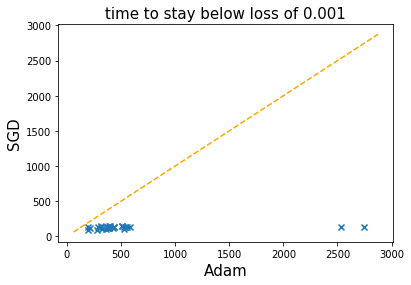

In [253]:
opt_path = OptPath(max_iter=3000, tol=1e-3)
kappas = [10**8] #[1, 10, 100, 1000, 10**4, 10**8]
lrs = [0.1] #[1,1e-1,1e-2]
lambda_max = 100
d = 10
n_runs = 30

for k in kappas:
    print('kappa:', k)
    lambda_min = lambda_max / k
    
    pairs = []
    for _ in tqdm.tqdm(range(n_runs)):
        # grid search for learning rate for adam
        adam_time = opt_path.max_iter + 10
        best_lr = None
        adam_last_dist = None
        for lr in lrs:
            x0 = np.random.uniform(2, 10, d)
            criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max)
            opt_path.get_path(criteria, x0, lr=lr, opt=torch.optim.Adam)
            t = opt_path.get_loss_time()
            if t < adam_time:
                best_lr = lr
                adam_last_dist = np.linalg.norm(opt_path.x_path[-1])
            adam_time = min(adam_time, t)
        
        sgd_opt_lr = 0.0195 #2 / (lambda_min + lambda_max) 
        opt_path.get_path(criteria, x0, lr=sgd_opt_lr, opt=torch.optim.SGD)
        sgd_time = opt_path.get_loss_time()
        sgd_last_dist = np.linalg.norm(opt_path.x_path[-1])
        
        pairs.append([adam_time, sgd_time])
        print('chosen lr {}'.format(best_lr), 'times (adam, sgd):', adam_time, sgd_time, 'last dist:', adam_last_dist, sgd_last_dist)

    plot_pairs(pairs, title='time to stay below loss of {}'.format(opt_path.tol))
    plt.savefig('figures/loss_speed_{}_fix_lr.png'.format(k),bbox_inches='tight')
    plt.show()


k = [1, 10, 100, 1000, 1e4, 1e8], d=10, 3000 iterations maximum

![k=1](figures/loss_speed_1_fix_lr.png)
![k=10](figures/loss_speed_10_fix_lr.png)
![k=100](figures/loss_speed_100_fix_lr.png)
![k=1000](figures/loss_speed_1000_fix_lr.png)
![k=10000](figures/loss_speed_10000_fix_lr.png)
![k=1e8](figures/loss_speed_100000000_fix_lr.png)













  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 100000000













  3%|▎         | 1/30 [00:02<01:20,  2.78s/it]

chosen lr 0.1 times (adam, sgd): 344 136 last dist: 2.902431095257259 5.238307702073102













  7%|▋         | 2/30 [00:05<01:18,  2.80s/it]

chosen lr 0.1 times (adam, sgd): 367 82 last dist: 0.2974256811290866 5.352231267863509













 10%|█         | 3/30 [00:08<01:16,  2.82s/it]

chosen lr 0.1 times (adam, sgd): 380 153 last dist: 5.420717558801649 6.771941911486574













 13%|█▎        | 4/30 [00:11<01:13,  2.84s/it]

chosen lr 0.1 times (adam, sgd): 478 151 last dist: 1.0497139470330756 2.240330569786117













 17%|█▋        | 5/30 [00:14<01:10,  2.83s/it]

chosen lr 0.1 times (adam, sgd): 545 144 last dist: 0.2540307231992584 1.955210141194011













 20%|██        | 6/30 [00:17<01:10,  2.95s/it]

chosen lr 0.1 times (adam, sgd): 405 152 last dist: 1.8043337775439747 1.4991138628209146













 23%|██▎       | 7/30 [00:20<01:07,  2.95s/it]

chosen lr 0.1 times (adam, sgd): 444 131 last dist: 3.1378712794667143 4.091074787709417













 27%|██▋       | 8/30 [00:23<01:05,  2.99s/it]

chosen lr 0.1 times (adam, sgd): 502 139 last dist: 4.207194702447559 3.973588790642514













 30%|███       | 9/30 [00:26<01:03,  3.02s/it]

chosen lr 0.1 times (adam, sgd): 350 129 last dist: 5.674847649607273 6.863624835030284













 33%|███▎      | 10/30 [00:29<00:59,  2.99s/it]

chosen lr 0.1 times (adam, sgd): 429 144 last dist: 3.542769589780162 2.9224318914172702













 37%|███▋      | 11/30 [00:32<00:55,  2.93s/it]

chosen lr 0.1 times (adam, sgd): 338 123 last dist: 14.442054803741836 10.052428984017832













 40%|████      | 12/30 [00:35<00:52,  2.94s/it]

chosen lr 0.1 times (adam, sgd): 745 41 last dist: 15.818863966512787 14.516392262593348













 43%|████▎     | 13/30 [00:38<00:50,  2.95s/it]

chosen lr 0.1 times (adam, sgd): 619 143 last dist: 2.81356248536637 0.6590800556415932













 47%|████▋     | 14/30 [00:41<00:46,  2.93s/it]

chosen lr 0.1 times (adam, sgd): 502 127 last dist: 13.740872251597937 10.609403931057113













 50%|█████     | 15/30 [00:43<00:43,  2.91s/it]

chosen lr 0.1 times (adam, sgd): 626 162 last dist: 3.890129848225057 0.8809357652746983













 53%|█████▎    | 16/30 [00:46<00:40,  2.89s/it]

chosen lr 0.1 times (adam, sgd): 434 113 last dist: 1.313332966928222 3.7426803187812254













 57%|█████▋    | 17/30 [00:49<00:37,  2.89s/it]

chosen lr 0.1 times (adam, sgd): 383 148 last dist: 0.418795424186994 4.212160670517021













 60%|██████    | 18/30 [00:52<00:33,  2.83s/it]

chosen lr 0.1 times (adam, sgd): 299 135 last dist: 0.7678091454885176 7.491617823079574













 63%|██████▎   | 19/30 [00:55<00:31,  2.86s/it]

chosen lr 0.1 times (adam, sgd): 464 109 last dist: 6.506843833678578 3.9887619809888952













 67%|██████▋   | 20/30 [00:57<00:27,  2.75s/it]

chosen lr 0.1 times (adam, sgd): 267 103 last dist: 3.510581007827707 4.635597180976614













 70%|███████   | 21/30 [01:00<00:24,  2.77s/it]

chosen lr 0.1 times (adam, sgd): 503 150 last dist: 2.309767307826877 9.46420127141572













 73%|███████▎  | 22/30 [01:03<00:22,  2.76s/it]

chosen lr 0.1 times (adam, sgd): 467 134 last dist: 2.046638103579535 6.399952107863107













 77%|███████▋  | 23/30 [01:06<00:19,  2.79s/it]

chosen lr 0.1 times (adam, sgd): 509 137 last dist: 0.06520407081570259 1.8934507571615706













 80%|████████  | 24/30 [01:08<00:16,  2.77s/it]

chosen lr 0.1 times (adam, sgd): 382 146 last dist: 1.8333858712229645 4.972929728371032













 83%|████████▎ | 25/30 [01:11<00:14,  2.82s/it]

chosen lr 0.1 times (adam, sgd): 481 154 last dist: 4.040061137425295 6.187843647679046













 87%|████████▋ | 26/30 [01:14<00:11,  2.88s/it]

chosen lr 0.1 times (adam, sgd): 490 120 last dist: 3.4147607992926736 7.029344167011629













 90%|█████████ | 27/30 [01:17<00:08,  2.87s/it]

chosen lr 0.1 times (adam, sgd): 603 150 last dist: 2.291965876062219 3.130752107472582













 93%|█████████▎| 28/30 [01:20<00:05,  2.86s/it]

chosen lr 0.1 times (adam, sgd): 633 150 last dist: 2.928686612103474 2.6433568601516586













 97%|█████████▋| 29/30 [01:23<00:02,  2.89s/it]

chosen lr 0.1 times (adam, sgd): 507 135 last dist: 1.9109704124783906 5.211705463976592













100%|██████████| 30/30 [01:26<00:00,  2.94s/it]

chosen lr 0.1 times (adam, sgd): 267 143 last dist: 0.6858332549907907 5.206071975309382


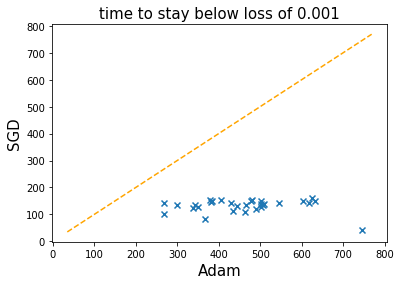

In [519]:
# changing to amsgrad won't help
opt_path = OptPath(max_iter=3000, tol=1e-3)
kappas = [10**8] #[1, 10, 100, 1000, 10**4, 10**8]
lrs = [0.1] #[1,1e-1,1e-2]
lambda_max = 100
d = 10
n_runs = 30

for k in kappas:
    print('kappa:', k)
    lambda_min = lambda_max / k
    
    pairs = []
    for _ in tqdm.tqdm(range(n_runs)):
        # grid search for learning rate for adam
        adam_time = opt_path.max_iter + 10
        best_lr = None
        adam_last_dist = None
        for lr in lrs:
            x0 = np.random.uniform(2, 10, d)
            criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max)
            opt_path.get_path(criteria, x0, lr=lr, opt=torch.optim.Adam, amsgrad=True)
            t = opt_path.get_loss_time()
            if t < adam_time:
                best_lr = lr
                adam_last_dist = np.linalg.norm(opt_path.x_path[-1])
            adam_time = min(adam_time, t)
        
        sgd_opt_lr = 0.0195 #2 / (lambda_min + lambda_max) 
        opt_path.get_path(criteria, x0, lr=sgd_opt_lr, opt=torch.optim.SGD)
        sgd_time = opt_path.get_loss_time()
        sgd_last_dist = np.linalg.norm(opt_path.x_path[-1])
        
        pairs.append([adam_time, sgd_time])
        print('chosen lr {}'.format(best_lr), 'times (adam, sgd):', adam_time, sgd_time, 'last dist:', adam_last_dist, sgd_last_dist)

    plot_pairs(pairs, title='time to stay below loss of {}'.format(opt_path.tol))
    #plt.savefig('figures/loss_speed_{}_fix_lr.png'.format(k),bbox_inches='tight')
    plt.show()


**The result here contradicts with the optimal SGD learning rate result** as fixed learning rate SGD took far fewer iterations to reach low loss value. What just happened?

Let's revisit how the optimal learning rate is determined by looking at the gradient descent proof

$$Q(\theta_{t+1} - \theta^*) = (I - \eta \Lambda) Q (\theta_t - \theta^*)$$

To ensure convergence, we require $|1 - \eta \lambda_i| < 1$ for all $i$. To ensure this condition, we just need the most extreme eigenvalue to satisfy the constraint, and the rest with follow suit (this is b/c $\max(\{|1-\eta \lambda_i|\}) = \max(\{|1-\eta \lambda_\max|, |1 - \eta \lambda_\min|\}) $). The process is illustrated by the following plot.

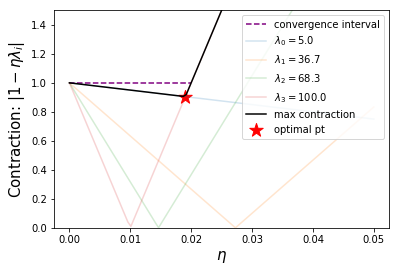

In [648]:
lambda_min = 5
lambda_max = 100
d = 4
criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max) # lambda is from small to large

def convergence_rate(eta, lambda_i):
    return np.abs(1 - eta * lambda_i)

converge_interval = np.linspace(0, 2 / lambda_max, 100)
plt.plot(converge_interval, np.ones_like(converge_interval), '--', color='purple', label='convergence interval')
k = lambda_max / lambda_min
plt.scatter([2 / (lambda_min + lambda_max)], [(k-1) / (k+1)], marker='*', s=200, color='red',
            label='optimal pt')

eta = np.linspace(0, 0.05, 100)
max_rate = np.zeros(100)
for i, lambda_i in enumerate(Lambda):
    rate = convergence_rate(eta, lambda_i)
    max_rate = np.maximum(rate, max_rate)
    plt.plot(eta, rate, alpha=0.2,
             label=r'$\lambda_{}={:.1f}$'.format(i, lambda_i))
plt.plot(eta, max_rate, label='max contraction', color='k')
plt.legend()
plt.ylabel('Contraction: $|1 - \eta \lambda_i|$', fontsize=15)
plt.ylim(0, 1.5)
plt.xlabel('$\eta$', fontsize=15)
plt.savefig('figures/GDproof.png')
plt.show()

![GDprove](figures/GDproof.png)

To converge, we require $\eta$ to be in the region where thet black line is below $1$. The contraction constant is determined by the slowest component, thus we just set $\eta$ to the lowest point of the black curve, which yield $\eta=2/(\lambda_\min + \lambda_\max)$.

Although this learning rate is optimal for convergence speed, it says nothing about how fast progress are made (it only specifies the contraction constant for the worst possible direction). Reading off the plot, if we move to the left of the optimal point, we would have increased convergence speed for the first two eigenvectors, while sacrificing the other two eigenvectors' convergence speed at a smaller amount because eigenvalue dictates the slope of the contraction constant. That is, overall, **we should expect slower convergence due to slower speed on smallest eigenvalue direction, but faster progress for large eigenvalue direction**. 

The above discussion is still based on closing the error gap along eigenvector direction, what about the loss? Quadratic loss is again more biased torwards large eigenvalue direction. In general, a quadratic loss can be written as

$$(\theta - \theta^*)^\intercal H (\theta - \theta^*) + c$$
with $H = X^\intercal X$ in our setting and c is some constant determined by $y$ and $X$. Rewriting again in the eigenspace of $X^\intercal X$ yields
$$(Q (\theta - \theta^*))^\intercal \Lambda (Q (\theta - \theta^*)) + c$$

This means error in the largest eigenvalue direction is most important for the loss, and decreasing them fast is going to make rapid progress in terms of loss value. This explains the faster behavior of SGD albeit using a non optimal learning rate.

**why does SGD appear to be robust to condition number?**

The above explaination justifies SGD's ability to decrease loss faster than using the optimal rate, but it still doesn't explain why SGD using a single learning rate decreases loss faster than Adam. Isn't the opposite should be true? As it turns out, the problem lies in the fact that we have been fixing $\lambda_\max$ be the same and decrease $\lambda_min$. Recall the convergence range shown in the last plot lies in the range of $(0, 2/\lambda_\max)$, which has nothing to do with $\lambda_\min$. Furthermore, to drive the error down fast, SGD just need a fixed learning rate of $1/\lambda_\max$ (the largest eigenvalue direction converge in 1 step). Thus, in the next experiment, we fix $\lambda_\min=0.01$ and vary $\lambda_\max$ instead.












  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 10000













  3%|▎         | 1/30 [00:02<01:10,  2.43s/it]

chosen lr 0.1 times (adam, sgd): 273 3001 last dist: 0.18036800768529374 0.9688331574158372













  7%|▋         | 2/30 [00:04<01:07,  2.41s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 3.8687333878956895 3.6707448851471582













 10%|█         | 3/30 [00:06<01:02,  2.33s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 3.1510258489266385 5.0709467156698524













 13%|█▎        | 4/30 [00:09<00:59,  2.29s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 1.530055166453362 1.7104575457772648













 17%|█▋        | 5/30 [00:11<00:56,  2.28s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 0.6376478365049242 4.48766817636462













 20%|██        | 6/30 [00:13<00:54,  2.25s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 2.5482708317690053 1.5202651063383532













 23%|██▎       | 7/30 [00:15<00:51,  2.25s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 3.610853433914556 5.8160364301612955













 27%|██▋       | 8/30 [00:18<00:49,  2.24s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 2.2581729417014973 2.7886336023583













 30%|███       | 9/30 [00:20<00:47,  2.25s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 1.2546412893470027 4.947124991098931













 33%|███▎      | 10/30 [00:22<00:47,  2.36s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 3.9539696163893576 6.148876700557383













 37%|███▋      | 11/30 [00:25<00:43,  2.31s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 2.6420460523264864 1.5492201196619457













 40%|████      | 12/30 [00:27<00:40,  2.27s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 1.1062854512548104 1.092840972700806













 43%|████▎     | 13/30 [00:29<00:38,  2.25s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 5.170221318176906 3.655201276055381













 47%|████▋     | 14/30 [00:31<00:36,  2.27s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 1.1346687127095834 7.1346101852406365













 50%|█████     | 15/30 [00:34<00:33,  2.27s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 3.3860575079780006 0.6370792162625734













 53%|█████▎    | 16/30 [00:36<00:31,  2.22s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 3.29489918544968 1.4141349167645476













 57%|█████▋    | 17/30 [00:38<00:28,  2.21s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 2.3990296951003964 0.9918290207550474













 60%|██████    | 18/30 [00:40<00:27,  2.27s/it]

chosen lr 0.1 times (adam, sgd): 455 3001 last dist: 0.047497455325615036 2.706931372683285













 63%|██████▎   | 19/30 [00:43<00:25,  2.29s/it]

chosen lr 0.1 times (adam, sgd): 3001 149 last dist: 0.8786583609594885 0.07241741312791532













 67%|██████▋   | 20/30 [00:45<00:22,  2.27s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 1.5276027877836735 0.4559242052205149













 70%|███████   | 21/30 [00:47<00:20,  2.23s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 1.1745211659782078 4.280871961064664













 73%|███████▎  | 22/30 [00:49<00:17,  2.20s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 3.3117495219809494 2.8400880736036025













 77%|███████▋  | 23/30 [00:51<00:15,  2.18s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 2.7645739680666823 1.8145752259656014













 80%|████████  | 24/30 [00:53<00:13,  2.20s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 4.0713324083699245 5.182745016183481













 83%|████████▎ | 25/30 [00:56<00:11,  2.22s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 3.254775265706799 0.9452967150814576













 87%|████████▋ | 26/30 [00:58<00:08,  2.21s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 1.6447769641794001 0.5007465270583813













 90%|█████████ | 27/30 [01:00<00:06,  2.21s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 1.9405961082357843 1.2940884857571828













 93%|█████████▎| 28/30 [01:02<00:04,  2.22s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 4.51988267831089 3.7144366632911













 97%|█████████▋| 29/30 [01:05<00:02,  2.21s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 5.005258533721788 5.120166447441839













100%|██████████| 30/30 [01:07<00:00,  2.19s/it]

chosen lr 0.1 times (adam, sgd): 3001 3001 last dist: 3.975408728967482 4.650089227051343


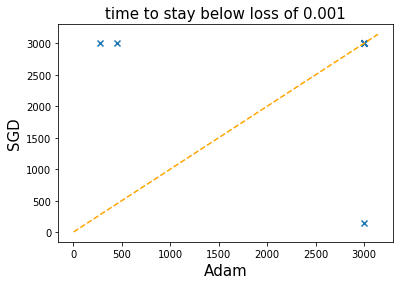












  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 100000000













  3%|▎         | 1/30 [00:02<01:03,  2.19s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 1.179619523439891 nan













  7%|▋         | 2/30 [00:04<01:01,  2.19s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 2.450529417736626 nan













 10%|█         | 3/30 [00:06<00:59,  2.20s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 2.387181707578934 nan













 13%|█▎        | 4/30 [00:08<00:56,  2.19s/it]

chosen lr 0.1 times (adam, sgd): 2327 6002 last dist: 1.5823500921248044 nan













 17%|█▋        | 5/30 [00:10<00:54,  2.20s/it]

chosen lr 0.1 times (adam, sgd): 2994 6002 last dist: 5.474779563932208 nan













 20%|██        | 6/30 [00:13<00:54,  2.25s/it]

chosen lr 0.1 times (adam, sgd): 696 6002 last dist: 0.1931833651362878 nan













 23%|██▎       | 7/30 [00:15<00:52,  2.26s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 14.43231832435018 nan













 27%|██▋       | 8/30 [00:17<00:48,  2.23s/it]

chosen lr 0.1 times (adam, sgd): 2978 6002 last dist: 0.32376209448687465 nan













 30%|███       | 9/30 [00:20<00:46,  2.23s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 1.2611775386665645 nan













 33%|███▎      | 10/30 [00:22<00:44,  2.23s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 2.6363510258787217 nan













 37%|███▋      | 11/30 [00:24<00:42,  2.23s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 2.8186991718347065 nan













 40%|████      | 12/30 [00:26<00:40,  2.23s/it]

chosen lr 0.1 times (adam, sgd): 2917 6002 last dist: 2.780593085713633 nan













 43%|████▎     | 13/30 [00:28<00:36,  2.16s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 2.2242282610135766 nan













 47%|████▋     | 14/30 [00:31<00:35,  2.23s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 7.103204124841763 nan













 50%|█████     | 15/30 [00:33<00:34,  2.28s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 0.8606900175532257 nan













 53%|█████▎    | 16/30 [00:35<00:31,  2.25s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 3.5718391969114416 nan













 57%|█████▋    | 17/30 [00:37<00:29,  2.24s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 3.223916491466768 nan













 60%|██████    | 18/30 [00:40<00:26,  2.25s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 0.4351981632708988 nan













 63%|██████▎   | 19/30 [00:42<00:24,  2.22s/it]

chosen lr 0.1 times (adam, sgd): 2994 6002 last dist: 11.9183754310277 nan













 67%|██████▋   | 20/30 [00:44<00:22,  2.23s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 3.5722737855187465 nan













 70%|███████   | 21/30 [00:46<00:19,  2.22s/it]

chosen lr 0.1 times (adam, sgd): 2991 6002 last dist: 12.35457968430827 nan













 73%|███████▎  | 22/30 [00:48<00:17,  2.17s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 1.9426425900455713 nan













 77%|███████▋  | 23/30 [00:51<00:15,  2.21s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 7.5726232469733725 nan













 80%|████████  | 24/30 [00:53<00:13,  2.22s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 2.0847717501703213 nan













 83%|████████▎ | 25/30 [00:55<00:11,  2.26s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 2.0839209352143757 nan













 87%|████████▋ | 26/30 [00:57<00:09,  2.25s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 2.9688812261502053 nan













 90%|█████████ | 27/30 [01:00<00:06,  2.23s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 13.186597652630033 nan













 93%|█████████▎| 28/30 [01:02<00:04,  2.19s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 1.4764192578352857 nan













 97%|█████████▋| 29/30 [01:04<00:02,  2.18s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 0.9252898125503838 nan













100%|██████████| 30/30 [01:06<00:00,  2.14s/it]

chosen lr 0.1 times (adam, sgd): 3001 6002 last dist: 3.1344681312293186 nan


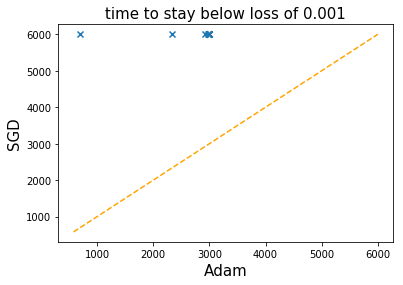

In [252]:
opt_path = OptPath(max_iter=3000, tol=1e-3)
kappas = [10**4, 10**8] #[1, 10, 100, 1000, 10**4, 10**8]
lrs = [0.1] #[1,1e-1,1e-2]
lambda_min = 0.01
d = 10
n_runs = 30

for k in kappas:
    print('kappa:', k)
    lambda_max = lambda_min * k
    
    pairs = []
    for _ in tqdm.tqdm(range(n_runs)):
        x0 = np.random.uniform(2, 10, d)
        criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max)
        
        # grid search for learning rate for adam
        adam_time = opt_path.max_iter + 10
        best_lr = None
        adam_last_dist = None
        for lr in lrs:
            opt_path.get_path(criteria, x0, lr=lr, opt=torch.optim.Adam)
            t = opt_path.get_loss_time()
            if t < adam_time:
                best_lr = lr
                adam_last_dist = np.linalg.norm(opt_path.x_path[-1])
            adam_time = min(adam_time, t)
        
        sgd_opt_lr = 0.0195 #2 / (lambda_min + lambda_max) 
        opt_path.get_path(criteria, x0, lr=sgd_opt_lr, opt=torch.optim.SGD)
        sgd_time = opt_path.get_loss_time()
        sgd_last_dist = np.linalg.norm(opt_path.x_path[-1])

        pairs.append([adam_time, sgd_time])
        print('chosen lr {}'.format(best_lr), 'times (adam, sgd):', adam_time, sgd_time, 'last dist:', adam_last_dist, sgd_last_dist)

    plot_pairs(pairs, title='time to stay below loss of {}'.format(opt_path.tol))
    plt.savefig('figures/loss_speed_{}_fix_lr_lambda_min.png'.format(k),bbox_inches='tight')
    plt.show()


k = [1, 10, 100, 1000, 1e4, 1e8], d=10, 3000 iterations maximum

![k=1](figures/loss_speed_1_fix_lr_lambda_min.png)
![k=10](figures/loss_speed_10_fix_lr_lambda_min.png)
![k=100](figures/loss_speed_100_fix_lr_lambda_min.png)
![k=1000](figures/loss_speed_1000_fix_lr_lambda_min.png)
![k=10000](figures/loss_speed_10000_fix_lr_lambda_min.png)
![k=10e8](figures/loss_speed_100000000_fix_lr_lambda_min.png)

SGD is slow in the first 3 cases because the learning rate is too small. SGD is slow in the last case because the learning rate is too large to converge (on the graph anything above 3000 means divergence).

However, **this is an unfair comparison** as SGD has no way to adjust learning rate. We enhance SGD by normalizing its gradient: $\theta_{t+1} = \theta_t - \eta \mathbb{E}(g) / \sqrt{\mathbb{E}(g^2 / d)}$


















  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 1000



















  3%|▎         | 1/30 [00:06<02:53,  6.00s/it]

chosen lr 0.1 times (adam, sgd): 4158 3752 last dist: 2.9583928340380407e-08 2.907048052765148e-22



















  7%|▋         | 2/30 [00:11<02:47,  5.99s/it]

chosen lr 0.1 times (adam, sgd): 891 3174 last dist: 9.991184613974468e-17 5.268988234917561e-22



















 10%|█         | 3/30 [00:17<02:40,  5.93s/it]

chosen lr 0.1 times (adam, sgd): 3869 2045 last dist: 2.8497214708046966e-07 4.693264491738304e-22



















 13%|█▎        | 4/30 [00:23<02:34,  5.93s/it]

chosen lr 0.1 times (adam, sgd): 3948 233 last dist: 4.345918363781545e-08 3.4496846709398156e-22



















 17%|█▋        | 5/30 [00:29<02:28,  5.92s/it]

chosen lr 0.1 times (adam, sgd): 2195 2798 last dist: 0.0002663524255626682 3.0282858985626613e-22



















 20%|██        | 6/30 [00:35<02:21,  5.88s/it]

chosen lr 0.1 times (adam, sgd): 3173 3581 last dist: 0.00010398237295184114 2.6089043530390385e-22



















 23%|██▎       | 7/30 [00:41<02:16,  5.91s/it]

chosen lr 0.1 times (adam, sgd): 372 3625 last dist: 2.5279276430303453e-14 2.843416008944667e-22



















 27%|██▋       | 8/30 [00:47<02:09,  5.87s/it]

chosen lr 0.1 times (adam, sgd): 2990 2908 last dist: 2.280371245577801e-14 3.128840990615975e-22



















 30%|███       | 9/30 [00:53<02:04,  5.93s/it]

chosen lr 0.1 times (adam, sgd): 794 3333 last dist: 7.113626547113539e-06 3.169733067316617e-22



















 33%|███▎      | 10/30 [00:59<01:58,  5.94s/it]

chosen lr 0.1 times (adam, sgd): 1701 953 last dist: 4.915502734913338e-22 2.549540004882239e-22



















 37%|███▋      | 11/30 [01:04<01:51,  5.87s/it]

chosen lr 0.1 times (adam, sgd): 3546 3699 last dist: 2.836640809684234e-22 2.748032036815276e-22



















 40%|████      | 12/30 [01:10<01:44,  5.82s/it]

chosen lr 0.1 times (adam, sgd): 2532 3542 last dist: 1.3606744470881023e-17 2.838672271318749e-22



















 43%|████▎     | 13/30 [01:16<01:38,  5.82s/it]

chosen lr 0.1 times (adam, sgd): 2635 3899 last dist: 9.845284130344864e-09 2.64859274841854e-22



















 47%|████▋     | 14/30 [01:22<01:32,  5.79s/it]

chosen lr 0.1 times (adam, sgd): 4517 3461 last dist: 6.419451113977903e-12 3.105142143224197e-22



















 50%|█████     | 15/30 [01:27<01:26,  5.76s/it]

chosen lr 0.1 times (adam, sgd): 2661 5509 last dist: 1.1942664528531364e-13 2.915716681766838e-06



















 53%|█████▎    | 16/30 [01:33<01:21,  5.82s/it]

chosen lr 0.1 times (adam, sgd): 2956 3679 last dist: 2.9801113888147986e-22 3.0894695429111623e-22



















 57%|█████▋    | 17/30 [01:39<01:16,  5.86s/it]

chosen lr 0.1 times (adam, sgd): 3731 3378 last dist: 3.644941734199465e-18 5.004685740986146e-22



















 60%|██████    | 18/30 [01:45<01:10,  5.84s/it]

chosen lr 0.1 times (adam, sgd): 2853 2599 last dist: 3.2891421551644526e-14 4.977987064539997e-22



















 63%|██████▎   | 19/30 [01:51<01:03,  5.80s/it]

chosen lr 0.1 times (adam, sgd): 4085 4129 last dist: 4.92580428004212e-22 3.036155884592143e-22



















 67%|██████▋   | 20/30 [01:57<00:58,  5.83s/it]

chosen lr 0.1 times (adam, sgd): 2697 388 last dist: 2.627433929238525e-11 2.0226879805489556e-22



















 70%|███████   | 21/30 [02:02<00:52,  5.82s/it]

chosen lr 0.1 times (adam, sgd): 1691 3412 last dist: 2.785671738232385e-22 4.679288140044794e-22



















 73%|███████▎  | 22/30 [02:08<00:46,  5.80s/it]

chosen lr 0.1 times (adam, sgd): 3404 3683 last dist: 1.0988351855143466e-15 3.6351558087931665e-22



















 77%|███████▋  | 23/30 [02:14<00:41,  5.87s/it]

chosen lr 0.1 times (adam, sgd): 1168 3049 last dist: 2.8768974891949696e-12 5.034240505465566e-22



















 80%|████████  | 24/30 [02:20<00:35,  5.87s/it]

chosen lr 0.1 times (adam, sgd): 268 3474 last dist: 6.271271605641469e-07 2.9986514517782023e-22



















 83%|████████▎ | 25/30 [02:26<00:29,  5.97s/it]

chosen lr 0.1 times (adam, sgd): 1692 2876 last dist: 1.5235811810455957e-21 4.847364796010351e-22



















 87%|████████▋ | 26/30 [02:32<00:23,  5.88s/it]

chosen lr 0.1 times (adam, sgd): 4273 3879 last dist: 0.005769751415473089 4.697370652706003e-22



















 90%|█████████ | 27/30 [02:38<00:17,  5.90s/it]

chosen lr 0.1 times (adam, sgd): 3276 1023 last dist: 4.730048041518366e-06 2.3971142720425236e-22



















 93%|█████████▎| 28/30 [02:44<00:11,  5.87s/it]

chosen lr 0.1 times (adam, sgd): 3094 857 last dist: 0.022382711074733642 2.4630952199704484e-22



















 97%|█████████▋| 29/30 [02:49<00:05,  5.85s/it]

chosen lr 0.1 times (adam, sgd): 4016 1148 last dist: 2.6415002943968585e-07 4.297313820643735e-22



















100%|██████████| 30/30 [02:55<00:00,  5.86s/it]

chosen lr 0.1 times (adam, sgd): 2549 975 last dist: 1.0373211378680143e-15 2.270195749513953e-22


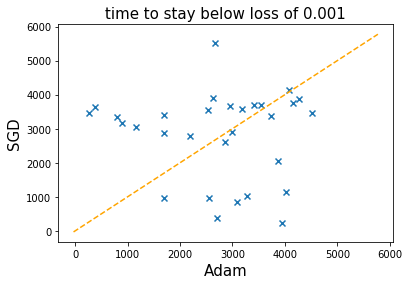


















  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 10000



















  3%|▎         | 1/30 [00:05<02:35,  5.36s/it]

chosen lr 0.1 times (adam, sgd): 9731 7641 last dist: 0.39939943655763627 0.0025516596681834144



















  7%|▋         | 2/30 [00:10<02:31,  5.43s/it]

chosen lr 0.1 times (adam, sgd): 8410 7760 last dist: 0.13747818491876113 0.002402116088526735



















 10%|█         | 3/30 [00:16<02:26,  5.43s/it]

chosen lr 0.1 times (adam, sgd): 6094 7130 last dist: 0.06917532017566164 0.0015882475480391723



















 13%|█▎        | 4/30 [00:22<02:22,  5.49s/it]

chosen lr 0.1 times (adam, sgd): 7029 6999 last dist: 0.08942796229468868 0.0009694896412278719



















 17%|█▋        | 5/30 [00:27<02:18,  5.54s/it]

chosen lr 0.1 times (adam, sgd): 5325 4658 last dist: 0.02153871732686755 0.0017774674629579604



















 20%|██        | 6/30 [00:33<02:12,  5.51s/it]

chosen lr 0.1 times (adam, sgd): 7488 7544 last dist: 0.011237755171982817 0.0020043745594298386



















 23%|██▎       | 7/30 [00:38<02:06,  5.52s/it]

chosen lr 0.1 times (adam, sgd): 6372 7907 last dist: 0.008501070973034285 0.003587392610590101



















 27%|██▋       | 8/30 [00:44<02:01,  5.51s/it]

chosen lr 0.1 times (adam, sgd): 8450 7771 last dist: 0.19954701827951116 0.0025685000630573883



















 30%|███       | 9/30 [00:49<01:55,  5.52s/it]

chosen lr 0.1 times (adam, sgd): 8580 8501 last dist: 0.030253419354254657 0.015128928315960324



















 33%|███▎      | 10/30 [00:55<01:51,  5.55s/it]

chosen lr 0.1 times (adam, sgd): 8721 3822 last dist: 0.1873232878006408 4.654862573497142e-06



















 37%|███▋      | 11/30 [01:01<01:46,  5.62s/it]

chosen lr 0.1 times (adam, sgd): 5904 6188 last dist: 0.2795009970802053 0.0004834423229696267



















 40%|████      | 12/30 [01:06<01:40,  5.61s/it]

chosen lr 0.1 times (adam, sgd): 7938 2523 last dist: 0.18421520622103738 1.0972697176720586e-06



















 43%|████▎     | 13/30 [01:12<01:34,  5.54s/it]

chosen lr 0.1 times (adam, sgd): 10001 6534 last dist: 1.4236242529997518 0.0007276472483020981



















 47%|████▋     | 14/30 [01:17<01:29,  5.57s/it]

chosen lr 0.1 times (adam, sgd): 10001 7848 last dist: 1.6541167900657923 0.0025994108648166466



















 50%|█████     | 15/30 [01:23<01:24,  5.63s/it]

chosen lr 0.1 times (adam, sgd): 6453 312 last dist: 0.005380996978701076 2.8853242031452968e-05



















 53%|█████▎    | 16/30 [01:29<01:19,  5.67s/it]

chosen lr 0.1 times (adam, sgd): 538 6187 last dist: 0.0007743343535294844 0.0013982031529091948



















 57%|█████▋    | 17/30 [01:34<01:13,  5.65s/it]

chosen lr 0.1 times (adam, sgd): 10001 3422 last dist: 3.395320965633525 3.99036820786916e-06



















 60%|██████    | 18/30 [01:40<01:06,  5.57s/it]

chosen lr 0.1 times (adam, sgd): 10001 7058 last dist: 0.6305922510840701 0.001199171529156696



















 63%|██████▎   | 19/30 [01:45<01:01,  5.60s/it]

chosen lr 0.1 times (adam, sgd): 8702 7346 last dist: 0.056071585352098385 0.0016662862425828727



















 67%|██████▋   | 20/30 [01:51<00:55,  5.59s/it]

chosen lr 0.1 times (adam, sgd): 7589 7747 last dist: 0.02251575679503106 0.002530756629550358



















 70%|███████   | 21/30 [01:56<00:50,  5.57s/it]

chosen lr 0.1 times (adam, sgd): 10001 3093 last dist: 0.7240125605338433 3.743955665944859e-06



















 73%|███████▎  | 22/30 [02:02<00:44,  5.55s/it]

chosen lr 0.1 times (adam, sgd): 10001 6657 last dist: 0.7990610771792175 0.0012203535339065962



















 77%|███████▋  | 23/30 [02:07<00:38,  5.54s/it]

chosen lr 0.1 times (adam, sgd): 10001 3474 last dist: 1.1152807963276823 1.0518891658436324e-05



















 80%|████████  | 24/30 [02:13<00:33,  5.51s/it]

chosen lr 0.1 times (adam, sgd): 10001 7868 last dist: 0.4870281052712059 0.002385589324947529



















 83%|████████▎ | 25/30 [02:19<00:27,  5.54s/it]

chosen lr 0.1 times (adam, sgd): 6688 3179 last dist: 0.09139913546830962 4.752214419073135e-06



















 87%|████████▋ | 26/30 [02:24<00:22,  5.58s/it]

chosen lr 0.1 times (adam, sgd): 460 7419 last dist: 0.01735039051901688 0.00186433952756894



















 90%|█████████ | 27/30 [02:30<00:16,  5.55s/it]

chosen lr 0.1 times (adam, sgd): 6844 7539 last dist: 0.06366482890689504 0.0023396402079980077



















 93%|█████████▎| 28/30 [02:35<00:11,  5.61s/it]

chosen lr 0.1 times (adam, sgd): 10001 7589 last dist: 1.4436452659171515 0.0019381900815093336



















 97%|█████████▋| 29/30 [02:41<00:05,  5.58s/it]

chosen lr 0.1 times (adam, sgd): 7724 3896 last dist: 0.1482810176224123 4.773422463520622e-06



















100%|██████████| 30/30 [02:46<00:00,  5.54s/it]

chosen lr 0.1 times (adam, sgd): 10001 7697 last dist: 1.7027427290290431 0.0025514557529192476


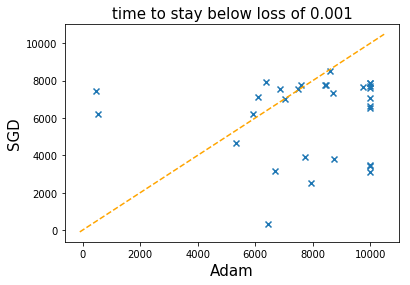


















  0%|          | 0/30 [00:00<?, ?it/s]

kappa: 100000000



















  3%|▎         | 1/30 [00:05<02:33,  5.29s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 3.0130156864628828 6.282013632551332



















  7%|▋         | 2/30 [00:10<02:29,  5.34s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 2.6278065932208357 5.189816069507853



















 10%|█         | 3/30 [00:16<02:23,  5.32s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 4.0016064224935395 2.928596137047259



















 13%|█▎        | 4/30 [00:21<02:18,  5.33s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 1.971169206655016 5.003493600244428



















 17%|█▋        | 5/30 [00:26<02:13,  5.32s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 0.7700059086262939 2.2819999323629427



















 20%|██        | 6/30 [00:32<02:10,  5.42s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 4.451003201736373 3.5161194708161174



















 23%|██▎       | 7/30 [00:37<02:04,  5.41s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 9.773617612989987 11.369515804757304



















 27%|██▋       | 8/30 [00:43<01:59,  5.41s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 1.8852050489421062 8.06182145046056



















 30%|███       | 9/30 [00:48<01:53,  5.39s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 1.9125931401058704 2.6069990508203222



















 33%|███▎      | 10/30 [00:54<01:49,  5.49s/it]

chosen lr 0.1 times (adam, sgd): 593 10001 last dist: 0.1555104841912186 6.8454993256456875



















 37%|███▋      | 11/30 [00:59<01:43,  5.43s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 3.1870403688320783 4.898767274723666



















 40%|████      | 12/30 [01:05<01:38,  5.49s/it]

chosen lr 0.1 times (adam, sgd): 10001 731 last dist: 1.0326352676286352 0.18844397667546947



















 43%|████▎     | 13/30 [01:10<01:33,  5.47s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 3.535137609544345 10.233217543804844



















 47%|████▋     | 14/30 [01:16<01:30,  5.66s/it]

chosen lr 0.1 times (adam, sgd): 681 302 last dist: 2.8623746774906906 2.4548665423119718



















 50%|█████     | 15/30 [01:22<01:23,  5.58s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 1.4572255163435148 3.016155754312443



















 53%|█████▎    | 16/30 [01:27<01:17,  5.53s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 3.903318630313974 6.7169461344046475



















 57%|█████▋    | 17/30 [01:32<01:10,  5.46s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 8.238054781591913 14.472263655377583



















 60%|██████    | 18/30 [01:38<01:07,  5.59s/it]

chosen lr 0.1 times (adam, sgd): 763 687 last dist: 5.169047838190509 10.720563953016226



















 63%|██████▎   | 19/30 [01:43<01:00,  5.50s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 2.1022095572513817 5.001762558918399



















 67%|██████▋   | 20/30 [01:49<00:54,  5.42s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 1.868053313419708 4.458887821735118



















 70%|███████   | 21/30 [01:54<00:48,  5.38s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 0.3280430563796189 4.0798679266716285



















 73%|███████▎  | 22/30 [02:00<00:43,  5.44s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 3.957211231795814 7.854294192075068



















 77%|███████▋  | 23/30 [02:05<00:37,  5.39s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 3.042228019028929 2.703159068792098



















 80%|████████  | 24/30 [02:10<00:32,  5.46s/it]

chosen lr 0.1 times (adam, sgd): 10001 896 last dist: 1.1962106580935719 0.9161186177834555



















 83%|████████▎ | 25/30 [02:16<00:27,  5.40s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 4.099820932858534 6.956941219975254



















 87%|████████▋ | 26/30 [02:21<00:21,  5.47s/it]

chosen lr 0.1 times (adam, sgd): 482 10001 last dist: 0.039621954384917245 2.5941700721979513



















 90%|█████████ | 27/30 [02:27<00:16,  5.41s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 2.147564247624443 1.2464611983457716



















 93%|█████████▎| 28/30 [02:32<00:10,  5.40s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 4.612372268478443 5.5503799033558545



















 97%|█████████▋| 29/30 [02:38<00:05,  5.45s/it]

chosen lr 0.1 times (adam, sgd): 10001 10001 last dist: 1.0530265753174215 4.83102900415829



















100%|██████████| 30/30 [02:43<00:00,  5.54s/it]

chosen lr 0.1 times (adam, sgd): 1078 9946 last dist: 0.2505775983944952 0.8670924238286486


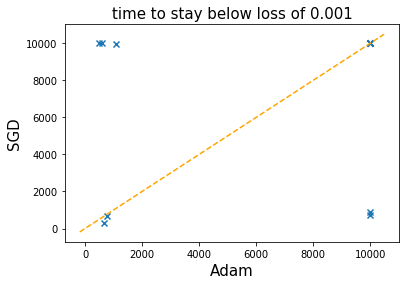

In [782]:
opt_path = OptPath(max_iter=10000, tol=1e-3)
kappas = [1000, 10**4, 10**8]#[1, 10, 100, 1000, 10**4, 10**8] #[1, 10, 100, 1000, 10**4, 10**8]
lrs = [0.1] #[1,1e-1,1e-2]
lambda_min = 0.01
d = 10
n_runs = 30

for k in kappas:
    print('kappa:', k)
    lambda_max = lambda_min * k
    
    pairs = []
    for _ in tqdm.tqdm(range(n_runs)):
        x0 = np.random.uniform(2, 10, d)
        criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max)
        
        # grid search for learning rate for adam
        adam_time = opt_path.max_iter * 3
        best_lr = None
        adam_last_dist = None
        for lr in lrs:
            opt_path.get_path(criteria, x0, lr=lr, opt=torch.optim.Adam, schedule=[0])
            t = opt_path.get_loss_time()
            if t < adam_time:
                best_lr = lr
                adam_last_dist = np.linalg.norm(opt_path.x_path[-1])
            adam_time = min(adam_time, t)
        
        sgd_time = opt_path.max_iter + 10
        best_lr = None
        sgd_last_dist = None
        for lr in lrs:
            opt_path.get_path(criteria, x0, lr=lr, opt=optimizers.AdaSGD, schedule=[0], momentum=0.9)
            t = opt_path.get_loss_time()
            if t < sgd_time:
                best_lr = lr
                sgd_last_dist = np.linalg.norm(opt_path.x_path[-1])
            sgd_time = min(sgd_time, t)

        pairs.append([adam_time, sgd_time])
        print('chosen lr {}'.format(best_lr), 'times (adam, sgd):', adam_time, sgd_time, 'last dist:', adam_last_dist, sgd_last_dist)

    plot_pairs(pairs, title='time to stay below loss of {}'.format(opt_path.tol))
    plt.savefig('figures/loss_speed_{}_fix_lr_lambda_min_adasgd.png'.format(k),bbox_inches='tight')
    plt.show()


k = [1, 10, 100, 1000, 1e4, 1e8], d=10, 3000 iterations maximum

![k=1](figures/loss_speed_1_fix_lr_lambda_min_adasgd.png)
![k=10](figures/loss_speed_10_fix_lr_lambda_min_adasgd.png)
![k=100](figures/loss_speed_100_fix_lr_lambda_min_adasgd.png)
![k=1000](figures/loss_speed_1000_fix_lr_lambda_min_adasgd.png)
![k=10000](figures/loss_speed_10000_fix_lr_lambda_min_adasgd.png)
![k=10e8a](figures/loss_speed_100000000_fix_lr_lambda_min_adasgd.png)

The result here shows that the enhanced SGD is definitely more promising, but struggles more with high condition number (**Or is it?**)

![fail_adam](figures/fail_adam.png)

This plot shows the real reason for adam failing (a case for k=$10^4$): the enhanced SGD (adasgd) oscillate more and earlier than Adam because its adaptive term is shared across directions, not per direction. In practice, however, **no sign shows AdaSGD should perform worse than Adam!**

While this enhancement is interesting, it still does not reach the true ability of SGD. The fastest SGD method should attack each direction in order and potentially increase learning rate as eigenvalue becomes smaller. What is a good way to <span style="color:red">guess eigenvalue</span>?

### What is preventing Adam from diverging?

From the above experiment, we observed that SGD is very sensitive $\lambda_\max$, but Adam seems not. In this section, we take a closer look at Adam's ability to not diverge.

In [267]:
opt_path = OptPath(max_iter=1000, tol=1e-6)

lambda_min = 0.1
lambda_max = 100
d = 3 # 6
x0 = np.random.uniform(2, 10, d) 
#x0 = np.array([5]*d)
criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max) # lambda is from small to large

We first verify the behavior of SGD. The first plot is the the training loss after taking log (showing that it didn't converge yet). The second and third plot show the error along each eigenvector dimension. The error decomposition plots nicely illustrate how SGD works. Since we operate in this quadratic loss realm, all errors can be separated along the eigenvector directions of the Hessian matrix $X^\intercal X$. For SGD, observe that the smallest eigenvector and the largest eigenvector has the same rate of error converging towards zero (Figure 3). This is exactly the behavior to expect when we set the optimal learning rate. Furthermore, it is clear from the third plot that error along each dimension is monotonically decreasing (the oscillation for orange line is likely an artifact of <span style="color:red">numerical error (? perhaps not since the rate of decrease follows other dimension from the point onwards)</span>). 

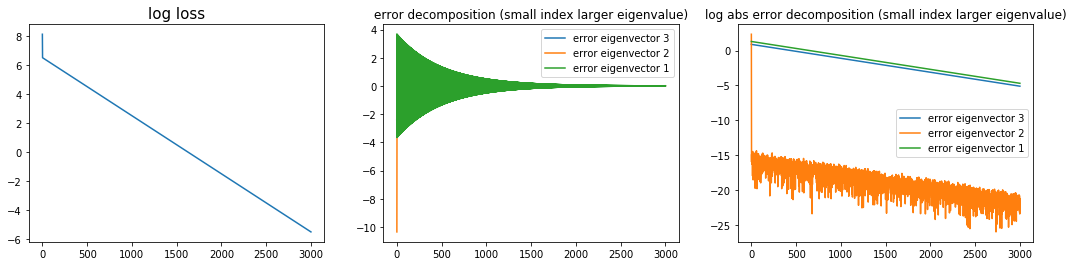

converge time: 3001 distance to solution: 0.01089588894759739


In [280]:
plt.gcf().set_size_inches(18, 4)
sgd_opt_lr = 2 / (lambda_min + lambda_max) 
opt_path.get_path(criteria, x0, lr=sgd_opt_lr, opt=torch.optim.SGD)

plt.subplot(1,3,1)
plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
plt.title('log loss', fontsize=15)

plt.subplot(1,3,2)
error = np.array([Q.dot(x) for x in opt_path.x_path])
for i in range(d):
    plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
plt.legend()
plt.title('error decomposition (small index larger eigenvalue)')

plt.subplot(1,3,3)
error = np.array([Q.dot(x) for x in opt_path.x_path])
for i in range(d):
    plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
plt.legend()
plt.title('log abs error decomposition (small index larger eigenvalue)')
plt.show()

print('converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))

Below, we show a setting in which SGD doesn't converge by setting $\eta=2/\lambda_\max$

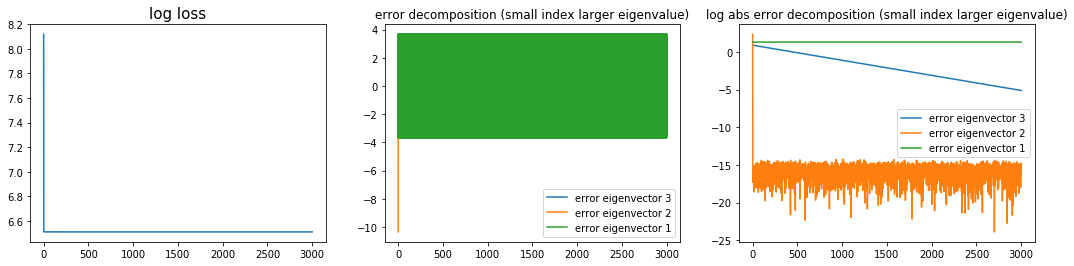

converge time: 3001 distance to solution: 3.6664417849024624


In [284]:
plt.gcf().set_size_inches(18, 4)
sgd_opt_lr = 2 / lambda_max #2 / (lambda_min + lambda_max)  # this should diverge
opt_path.get_path(criteria, x0, lr=sgd_opt_lr, opt=torch.optim.SGD)

plt.subplot(1,3,1)
plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
plt.title('log loss', fontsize=15)

plt.subplot(1,3,2)
error = np.array([Q.dot(x) for x in opt_path.x_path])
for i in range(d):
    plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
plt.legend()
plt.title('error decomposition (small index larger eigenvalue)')

plt.subplot(1,3,3)
error = np.array([Q.dot(x) for x in opt_path.x_path])
for i in range(d):
    plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
plt.legend()
plt.title('log abs error decomposition (small index larger eigenvalue)')
plt.show()

print('converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))

Next, we examine the behavior of Adam on the same problem with different learning rate

/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


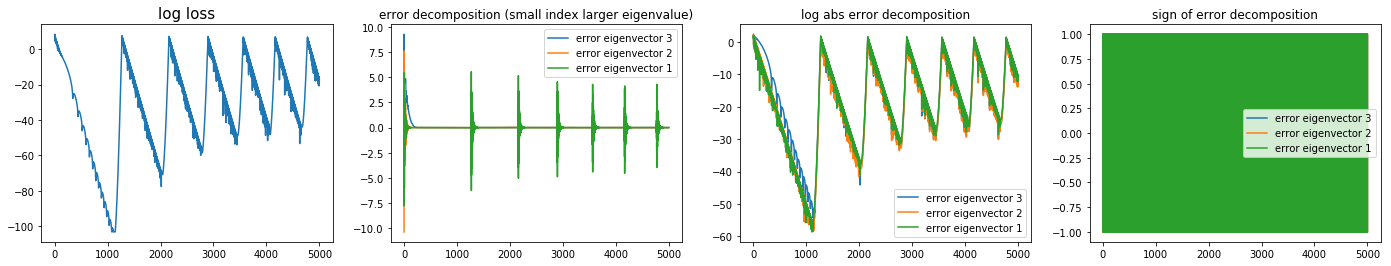

lr: 10 converge time: 5001 distance to solution: 3.230747799596051e-05


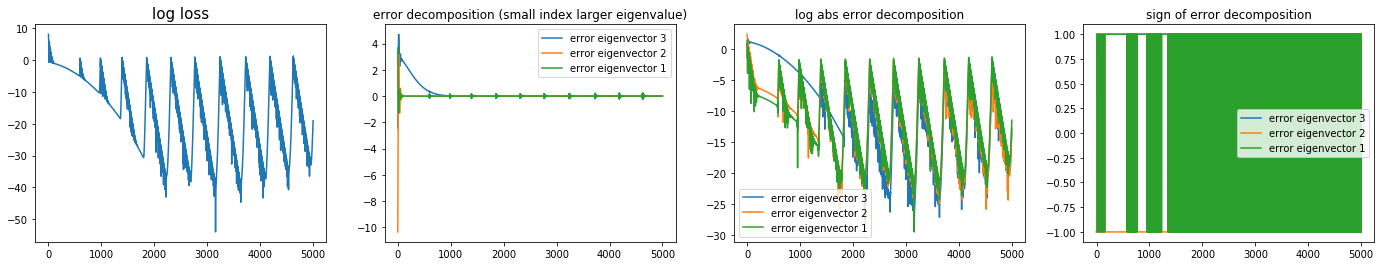

lr: 1 converge time: 5001 distance to solution: 1.0614724540269966e-05


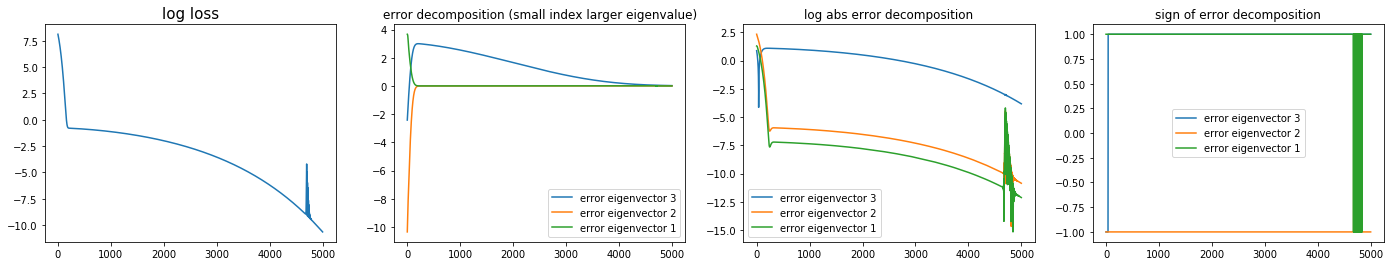

lr: 0.1 converge time: 5001 distance to solution: 0.021842871889587973


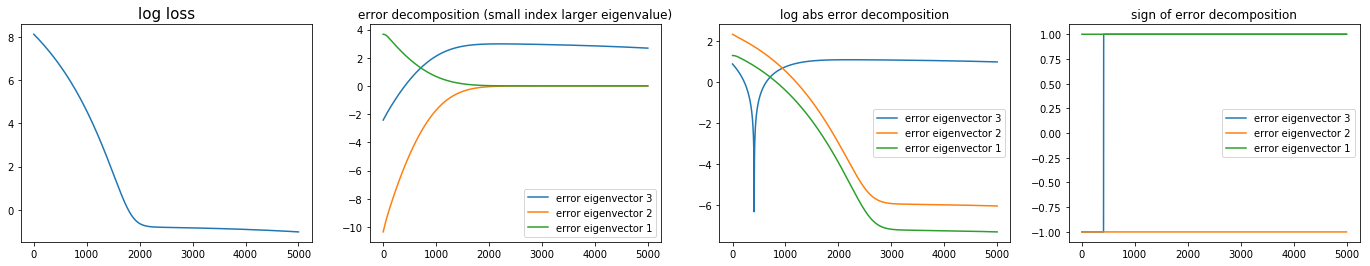

lr: 0.01 converge time: 5001 distance to solution: 2.6806145594143005


In [292]:
opt_path.max_iter = 5000
for lr in [10, 1, 0.1, 0.01]:
    opt_path.get_path(criteria, x0, lr=lr, opt=torch.optim.Adam)
    
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.title('log loss', fontsize=15)
    #plt.show()
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    #plt.show()
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))


One notable thing from this graph is that the first 2 eigenvectors, despite having different eigenvalue, goes to zero at similar rate. This differs from the behavior of SGD and is likely the reason why in deep learning people observe Adam to decrease loss faster. Moreover, different learning rate has drastically different behaviors reducing the error. Adam with large learning rate oscillate around $0$ and tend to have cycles of error erruptions, whereas errors with small learning rate has a much smoother behavior. Furthermore, the smallest eigenvalue direction have periods in which it would go away from the optimal solution.

One hypothesis for this pathological behavior associated with the small eigenvalue direction is illustrated in the following Figure:

![adam_small_eig](figures/adam_small_eig.png)



**burst in error**

This can be explained by observing the update for adam is $\mathbb{E}(\nabla L) / \mathbb{E}(\nabla L^2)$. If gradient $\nabla L$ is close enough to $0$, $\mathbb{E}(\nabla L) / \mathbb{E}(\nabla L^2)$ will be really large. This behavior is inevitable unless we control for the size of the denominator, e.g., using amsgrad.

/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


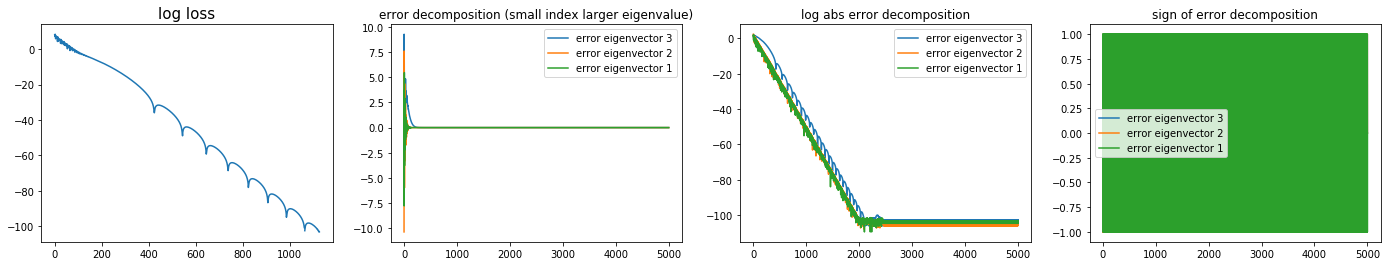

lr: 10 converge time: 417 distance to solution: 0.0


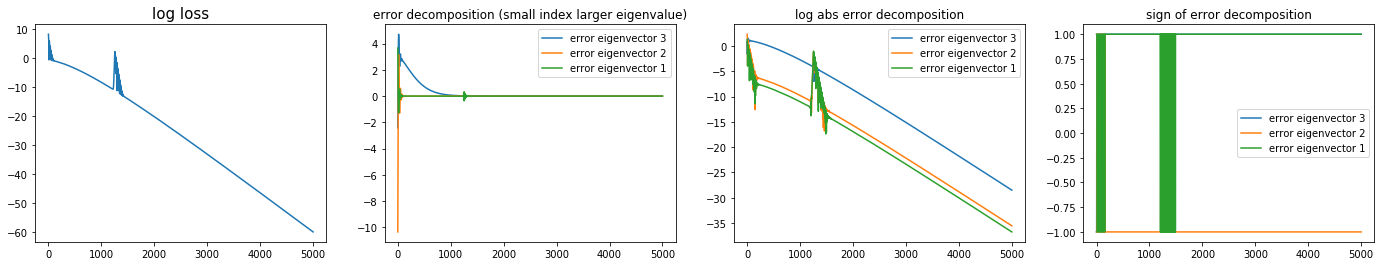

lr: 1 converge time: 2805 distance to solution: 4.2361527939173145e-13


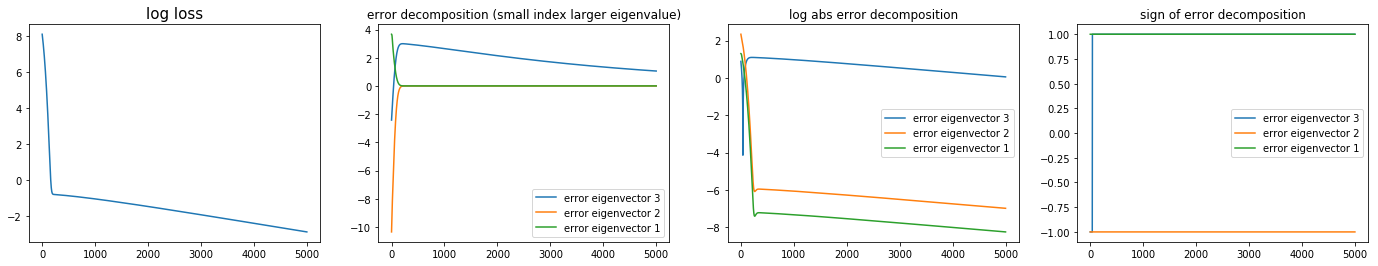

lr: 0.1 converge time: 5001 distance to solution: 1.0567011434304343


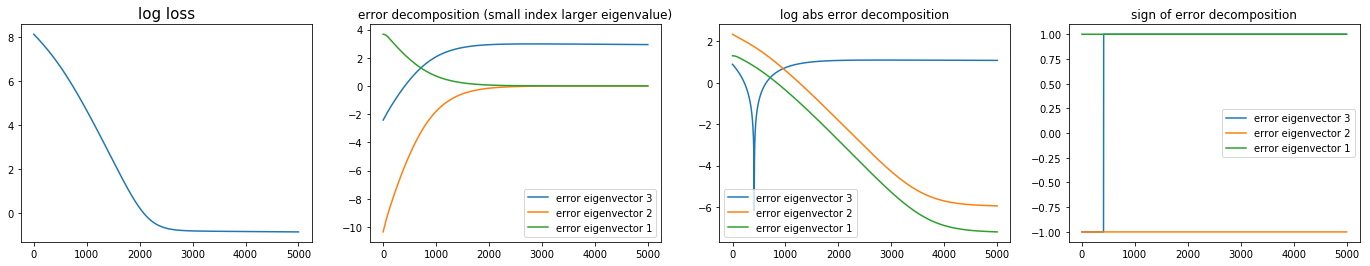

lr: 0.01 converge time: 5001 distance to solution: 2.9326408705927425


In [293]:
opt_path.max_iter = 5000
for lr in [10, 1, 0.1, 0.01]:
    opt_path.get_path(criteria, x0, lr=lr, opt=torch.optim.Adam, amsgrad=True)
    
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.title('log loss', fontsize=15)
    #plt.show()
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    #plt.show()
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))


Indeed, when we switched from Adam to ams grad, the spurious burst goes away. However, even with no bursts, it is still puzzling why the slowest eigenvalue direction is progressing much slower compared to other directions.

**The general case for Adam**

In [554]:
opt_path = OptPath(max_iter=1000, tol=1e-6)

lambda_min = 0.001
lambda_max = 100
d = 6 # 6
x0 = np.random.uniform(2, 10, d) 
#x0 = np.array([5]*d)
criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max, logscale=True) # lambda is from small to large

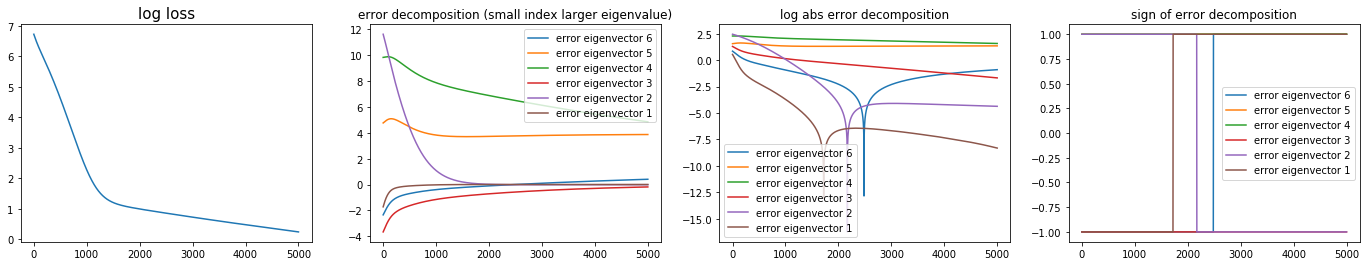

lr: 0.01 converge time: 5001 distance to solution: 6.223154279906005


In [555]:
opt_path.max_iter = 5000
for lr in [0.01]:
    opt_path.get_path(criteria, x0, record=True, lr=lr, opt=torch.optim.Adam, amsgrad=True)
    
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.title('log loss', fontsize=15)
    #plt.show()
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    #plt.show()
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))


Adam decrease loss for each direction at different rate, but **not following the order of eigenvalue**.

/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


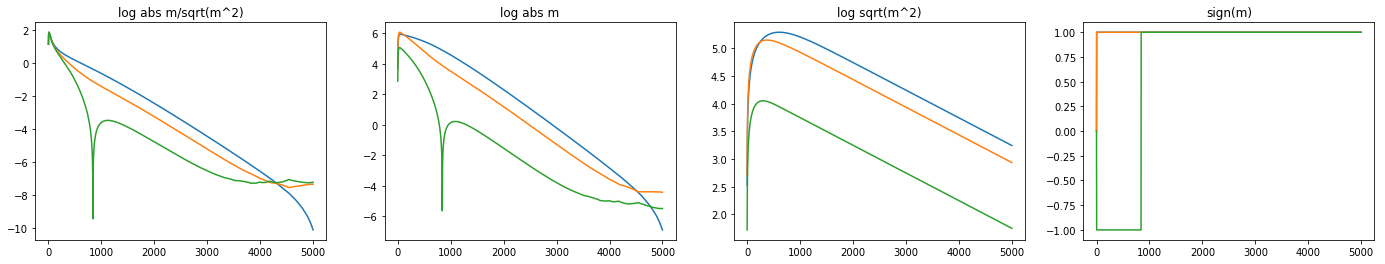

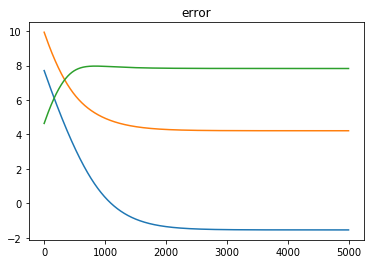

In [369]:
beta1, beta2 = 0.9, 0.999

plt.gcf().set_size_inches(24, 4)
plt.subplot(1,4,1)
for i in range(d):
    g = opt_path.opt_recorder.tracker[0]['grad'][i]
    # momentum 
    m = [0]
    for g_ in g:
        m.append(m[-1] * beta1 + (1-beta1) * g_)
    m2 = [0]
    for g_ in g:
        m2.append(m2[-1] * beta2 + (1-beta2) * g_**2)
    
    plt.title('log abs m/sqrt(m^2)')
    plt.plot(np.log(np.abs(np.array(m) / np.sqrt(m2))))

plt.subplot(1,4,2)
for i in range(d):
    g = opt_path.opt_recorder.tracker[0]['grad'][i]
    # momentum 
    m = [0]
    for g_ in g:
        m.append(m[-1] * beta1 + (1-beta1) * g_)
    plt.title('log abs m')
    plt.plot(np.log(np.abs(m)))

plt.subplot(1,4,3)
for i in range(d):
    g = opt_path.opt_recorder.tracker[0]['grad'][i]
    # grad^2
    m2 = [0]
    for g_ in g:
        m2.append(m2[-1] * beta2 + (1-beta2) * g_**2)
    plt.title('log sqrt(m^2)')
    plt.plot(np.log(np.sqrt(m2)))
    
plt.subplot(1,4,4)
for i in range(d):
    g = opt_path.opt_recorder.tracker[0]['grad'][i]
    # momentum 
    m = [0]
    for g_ in g:
        m.append(m[-1] * beta1 + (1-beta1) * g_)
    plt.title('sign(m)')
    plt.plot(np.sign(m))

plt.show()

error = opt_path.x_path
for i in range(d):
    plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
plt.title('error')
plt.show()


**reproducing the puzzling case (low eigenvalue dimension does not learn): by initializing the problem at the low eigenvalue direction**

In [551]:
opt_path = OptPath(max_iter=1000, tol=1e-6)

lambda_min = 0.001
lambda_max = 100
d = 6 # 6
x0 = np.random.uniform(2, 10, d) 
criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max) # lambda is from small to large

x1 = np.zeros_like(x0)
x1[0] = Q.dot(x0)[0]
x0 = Q.T.dot(x1)

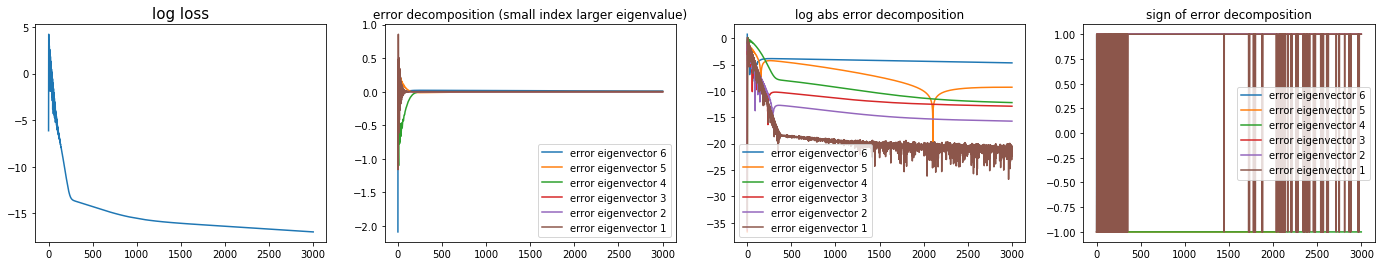

lr: 1 converge time: 3001 distance to solution: 0.009172956783056258


In [543]:
opt_path.max_iter = 3000
for lr in [1]:#[1e-5, 1e-3, 1e-1, 1, 10, 100]:
    opt_path.get_path(criteria, x0, record=True, lr=lr, opt=torch.optim.Adam, amsgrad=True)
    
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.title('log loss', fontsize=15)
    #plt.show()
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    #plt.show()
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))


Apparently, it is still unable to speed up the solution. 
<span style="color:red">Why???</span>


In [489]:
opt_path = OptPath(max_iter=1000, tol=1e-6)

lambda_min = 0.001
lambda_max = 100
d = 2 # 6
x0 = np.random.uniform(2, 10, d) 
criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max) # lambda is from small to large

x1 = np.zeros_like(x0)
x1[0] = Q.dot(x0)[0]
x0 = Q.T.dot(x1)

/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


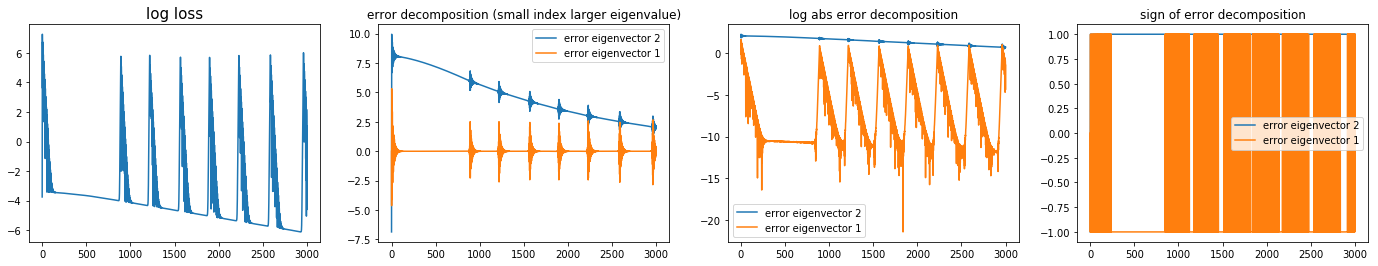

lr: 10 converge time: 3001 distance to solution: 2.1262999266094913


In [516]:
opt_path.max_iter = 3000
for lr in [10]:
    opt_path.get_path(criteria, x0, record=True, lr=lr, opt=torch.optim.Adam, amsgrad=False)
    
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.title('log loss', fontsize=15)
    #plt.show()
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    #plt.show()
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))


In this experiment, we sample starting point along the lowest eigenvalue direction. The plot shows that even in this simple setting, Adam with amsgrad is converging very slowly (other learning rate gives similar result).

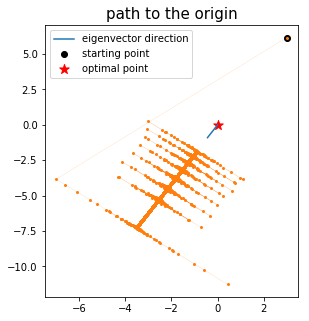

In [518]:
plt.subplot(1,2,1)
plt.plot([0, Q[0][0]], [0, Q[0][1]], label='eigenvector direction')
plt.scatter([opt_path.x_path[0][0]], [opt_path.x_path[0][1]], color='k', label='starting point')
plt.scatter([0], [0], color='r', marker='*', s=100, label='optimal point')

start = 0 #1800
end = -1 #2500
plt.plot(opt_path.x_path[start:end,0], opt_path.x_path[start:end,1], '-o', linewidth=0.1, markersize=2)
#plt.scatter(opt_path.x_path[:,0], opt_path.x_path[:,1])
#plt.xlim(1.0,1.02)
#plt.ylim(1,3)
#plt.xlim(0, 10)
#plt.ylim(0, 10)
plt.title('path to the origin', fontsize=15)
plt.legend()

# plt.subplot(1,2,2)
# plt.gcf().set_size_inches(5,5)
# plt.plot([0, Q[0][0]], [0, Q[0][1]], label='eigenvector direction')
# plt.scatter([opt_path.x_path[0][0]], [opt_path.x_path[0][1]], color='k', label='starting point')
# start = 0 #1800
# end = -1 #2500
# plt.plot(opt_path.x_path[start:end,0], opt_path.x_path[start:end,1], '-o', linewidth=0.1, markersize=2)
# #plt.scatter(opt_path.x_path[:,0], opt_path.x_path[:,1])
# plt.xlim(1.0,1.02)
# #plt.ylim(2.0,2.15)
# #plt.xlim(0, 10)
# plt.ylim(1, 3)
# plt.title('path to the origin (zoomed in view)', fontsize=15)
# #plt.legend()

plt.gcf().set_size_inches(10,5)
plt.show()


### Fitting low eigenvalue direction is bad

**because smallest eigenvalue direction is affected by training data the most; that's also why SGD generalizes well**

Here we show that a change in data sample will affect the smallest eigenvalue direction the most (standardize the data if not apparent). That is the direction with the smallest eigenvalue is the least reliable direction among all directions.

We use the notation $X^{-i}$ to denote the $i^{th}$ row of the design matrix is replaced by a different data point. Then we are interested in the change in solution as $X$ changes to $X^{-i}$. Assuming $\Lambda$ is non singular, we have $\theta = (X^\intercal X)^{-1} X^\intercal y$ and we want to measure $Q (\theta - \theta^{-i}) / Q \theta$

In [405]:
n = 500 # for CIFAR10 is 1000
datasetname = 'FMNIST'
downsample = False # for CIFAR10 is True
assert datasetname in ['CIFAR10', 'FMNIST']
if datasetname == 'CIFAR10':
    data = torchvision.datasets.CIFAR10('.', train=True)
elif datasetname == 'FMNIST':
    data = torchvision.datasets.FashionMNIST('.', train=True, download=True)
indices = list(np.random.permutation(len(data)))[:2*n] 
data1 = torch.utils.data.Subset(data,indices[:n])
data2 = torch.utils.data.Subset(data,indices[n:])

def getX_y(data, downsample=True):
    X = []
    y = []
    for d in data:
        x, t = d
        if downsample:
            if len(x.size) >= 3:
                x = np.array(x.resize((15,15))).sum(2).reshape(-1)
            else:
                x = np.array(x.resize((10,10))).reshape(-1)
        else:
            x = np.array(x).reshape(-1)
        X.append(x)
        y.append(t)
    return np.vstack(X).astype(np.float64), np.array(y).astype(np.float64)

X, y = getX_y(data1, downsample=downsample)  
X2, y2 = getX_y(data2, downsample=downsample)  

approximation is close: False
max approximation error: 0.018347994574330152
eigen values are sorted True
min eigen value: 0.0
kappa=inf


/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


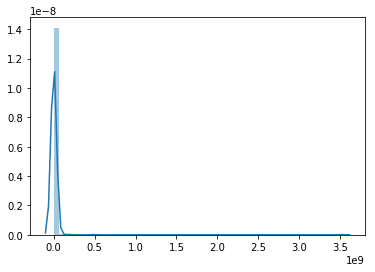

In [408]:
def eig_XT_X(X):
    u, s, Q = np.linalg.svd(X)
    real_s = np.zeros_like(X)
    m, n = X.shape
    if m > n:
        real_s[:n] = np.diag(s)
    else:
        real_s[:, :m] = np.diag(s)
    s = real_s
    eig_values = np.diag(s.T.dot(s)) # eigenvectors are rows of Q
    return u, s, Q, eig_values

u, s, Q, eig_values = eig_XT_X(X)

A = Q.T.dot(s.T).dot(s).dot(Q)
B = X.T.dot(X)
print('approximation is close:', np.allclose(A, B))
if not np.allclose(A, B):
    print('max approximation error:', np.abs(A-B).sum())
print('eigen values are sorted', np.allclose(eig_values, sorted(eig_values)[::-1]))
print('min eigen value:', eig_values[-1])
print('kappa={:e}'.format(eig_values[0]/eig_values[-1]))
sns.distplot(eig_values)

In [411]:
def getTheta(X, y, Q=None, s=None):
    if Q is None or s is None:
        return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    else:
        try:
            if X.shape[0] < X.shape[1]:
                raise
            return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        except:
            print('error inverting')
            s_inv = copy.deepcopy(s)
            s_inv[s_inv == 0] = -1
            s_inv = 1/s_inv
            s_inv[s_inv == -1] = 0
            return Q.T.dot(np.diag(s_inv)).dot(Q).dot(X.T).dot(y)

theta = getTheta(X, y, Q, eig_values)
thetas = [theta]

error inverting


In [412]:
for i in tqdm.tqdm(range(10)):
    index = np.random.randint(n)
    X_i = copy.deepcopy(X)
    y_i = copy.deepcopy(y)
    X_i[index] = X2[index]
    y_i[index] = y2[index]
    
    _, _, Q_i, eig_values_i = eig_XT_X(X)
    theta_i = getTheta(X_i, y_i, Q_i, eig_values_i)
    thetas.append(theta_i)






  0%|          | 0/10 [00:00<?, ?it/s]




 10%|█         | 1/10 [00:17<02:36, 17.35s/it]

error inverting







 20%|██        | 2/10 [00:26<01:58, 14.79s/it]

error inverting







 30%|███       | 3/10 [00:43<01:48, 15.47s/it]

error inverting







 40%|████      | 4/10 [00:56<01:28, 14.80s/it]

error inverting
error inverting







 50%|█████     | 5/10 [01:16<01:21, 16.23s/it]

error inverting







 60%|██████    | 6/10 [01:31<01:04, 16.04s/it]




 70%|███████   | 7/10 [01:50<00:50, 16.99s/it]

error inverting







 80%|████████  | 8/10 [02:09<00:35, 17.50s/it]

error inverting







 90%|█████████ | 9/10 [02:28<00:17, 17.88s/it]

error inverting







100%|██████████| 10/10 [02:47<00:00, 18.19s/it]

error inverting


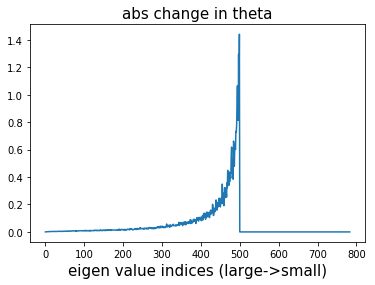

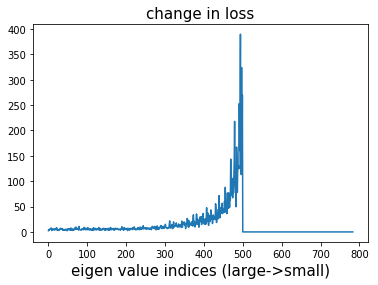

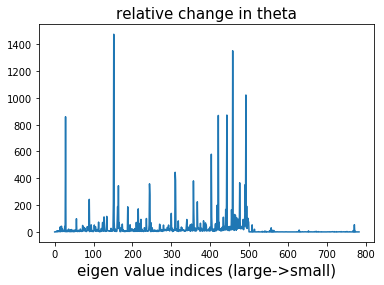

/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


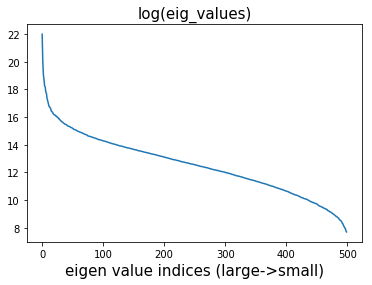

In [413]:
change = 0
for t in thetas[1:]:
    change += np.abs(Q.dot(thetas[0] - t))
    #change += np.abs(Q.dot(thetas[0] - t)/ Q.dot(thetas[0])) # relative
plt.plot(change)
plt.title('abs change in theta', fontsize=15)
plt.xlabel('eigen value indices (large->small)', fontsize=15)
plt.savefig('figures/theta_change_abs_{}'.format(datasetname))
plt.show()

change = 0
for t in thetas[1:]:
    #change += np.abs(Q.dot(thetas[0] - t))
    change += np.abs(Q.dot(thetas[0] - t)**2 * eig_values)
plt.plot(change)
plt.title('change in loss', fontsize=15)
plt.xlabel('eigen value indices (large->small)', fontsize=15)
plt.savefig('figures/theta_change_loss_{}'.format(datasetname))
plt.show()

change = 0
for t in thetas[1:]:
    #change += np.abs(Q.dot(thetas[0] - t))
    change += np.abs(Q.dot(thetas[0] - t)/ Q.dot(thetas[0])) # relative
plt.plot(change)
plt.title('relative change in theta', fontsize=15)
plt.xlabel('eigen value indices (large->small)', fontsize=15)
plt.savefig('figures/theta_change_rel_{}'.format(datasetname))
plt.show()

plt.title('log(eig_values)', fontsize=15)
plt.plot(np.log(eig_values))
plt.xlabel('eigen value indices (large->small)', fontsize=15)
plt.savefig('figures/theta_change_eig_{}'.format(datasetname))
plt.show()


On Fashion MNIST 500 randomly sampled datapoint 

![change_abs](figures/theta_change_abs_FMNIST.png)
![change_loss](figures/theta_change_loss_FMNIST.png)
![change_rel](figures/theta_change_rel_FMNIST.png)
![change_eig](figures/theta_change_eig_FMNIST.png)

On CIFAR10 1500 randomly sampled datapoints subsampled 15x15

![change_abs](figures/theta_change_abs_CIFAR10.png)
![change_loss](figures/theta_change_loss_CIFAR10.png)
![change_rel](figures/theta_change_rel_CIFAR10.png)
![change_eig](figures/theta_change_eig_CIFAR10.png)


The above result shows that the eigenvector associated with the smallest eigenvalue are indeed the least robust direction as it changes the most by perturbing 1 datapoint. Thus, directions with small eigenvalue are likely to increase the amount of distance traveled by the optimizer (an explanation is to consider equal variance for singular values, so small singular value inverse will have larger impact). The loss change and the relative change plots show similar trend (**but across runs there's variation, be caution**), this again suggest overfitting is related to the smallest eigenvalue direction.

However, what happens when $X^\intercal X$ is not invertible? We'd still have $X^\intercal X \theta = X^\intercal y$,  that is $Q^\intercal \Lambda Q \theta = X^\intercal y$, so we'd have $\Lambda Q \theta = Q X^\intercal y$. Note that although $X^\intercal X$ is not invertible (that is $\Lambda$ has $0$ entries), the last equation is still solvable as it is just a projection problem (another proof is to see that singular value matrix of $X$ must also have the same number of zero rows). In this case, $\theta$ is underdertermined, but we can still find the minimum norm solution by solving for $(Q X^\intercal y) / \Lambda$ after removing the zero rows (note here the division is elementwise; we used the fact that $Q\theta$ doesnt change the size of $\theta$). The trend we obtained is the same.

**The unstable nature of the small eigenvalue direction in fact justifies the utility of l2 regularization and explains why points along the SGD optimization path is generalizable**. This insighted had been pointed out in the Deep Learning book. The key insight is that both SGD and l2 regularization will place less weight on the small eigenvalue direction. This property is immediately clear for SGD from its convergence proof. For l2 regularization, the solution is 
$$\theta^{\alpha} = (X^\intercal X + \alpha I)^{-1} X^\intercal y$$

where $\alpha$ is the regularization strength. By rewriting this solution in terms of $\theta^*$, we observe that
\begin{align}
Q \theta^{\alpha} &= (\Lambda + \alpha I)^{-1} Q X^\intercal y \\
&= (\Lambda + \alpha I)^{-1} \Lambda \Lambda^{-1} Q X^\intercal y\\
&= \frac{1}{1 + \alpha / \Lambda} Q \theta^*
\end{align}

This means directions with small eigenvalue is penalyzed more. The effect is illustrated in the Figure below.

![SGD](figures/SGD_illustration.png)

**Summary**

To summarize, in least square regression setting, we observed the following phenomena

* Both Adam and SGD has difficulty converging with large condition number
* Adam is less sensitive to $\lambda_\max$ compared to SGD
* ~~Adam is faster than SGD in terms of progress on the loss function~~ (I expect this to be true when error along small eigenvalue directions are huge at initialization)
* SGD is expected to converge better because it relies less on the low eigenvalue directions b/c these directions are bad for generalization

Each of these phenomena listed here are observed when we move to deep learning archetectures. **See the introduction and related work on overleaf document for reference**.

## A foundamental flaw with Adam's adaptation scheme: The wild oscillation

The oscillation can be dampened in 3 ways:

* Learning rate decay on the training loss
* change to amsgrad
* custom learning rate decay

![adam_flaw](figures/flaw_adam.png)
<!--- ![adam_flaw2](figures/flaw_adam2.png) -->

This in fact illustrate how **Adam's adaptive scheme is foundamentally flawed**: once you enter low gradient region, 

In [783]:
opt_path = OptPath(max_iter=1000, tol=1e-6)

lambda_min = 0.01 #0.001
lambda_max = 100 #100
d = 100 # 6
x0 = np.random.uniform(2, 10, d) 
#x0 = np.array([5]*d)
criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max, logscale=True) # lambda is from small to large

AdaSGD


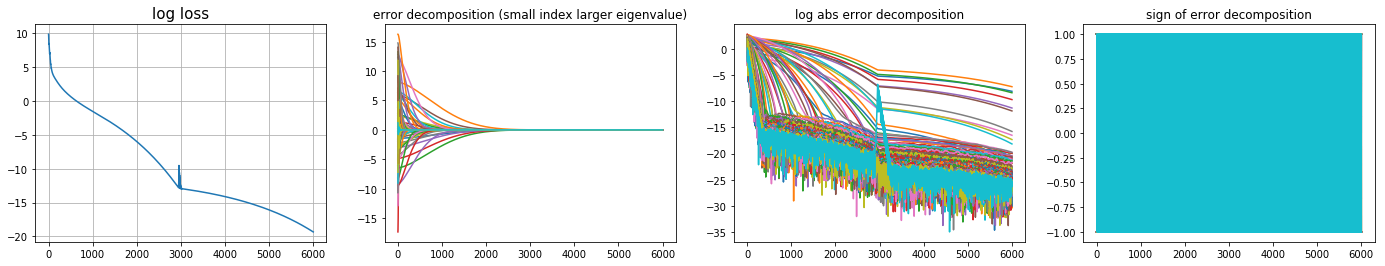

lr: 0.1 converge time: 6001 distance to solution: 0.0008498309654364564
SGD


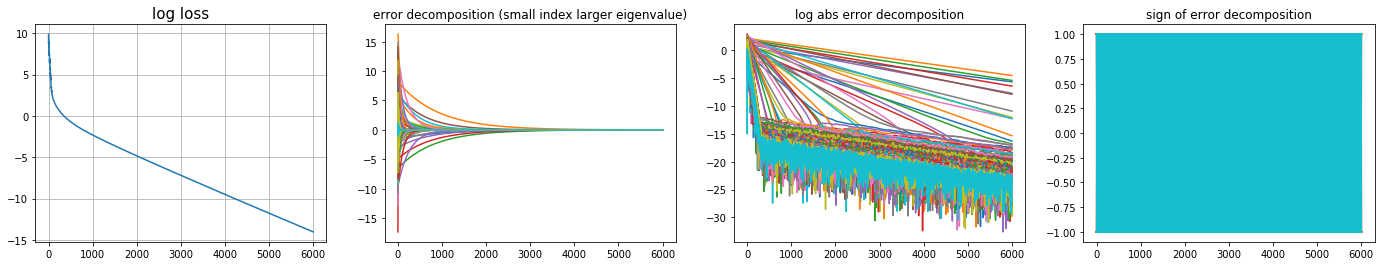

lr: 0.1 converge time: 6001 distance to solution: 0.012046213577937651
Adam


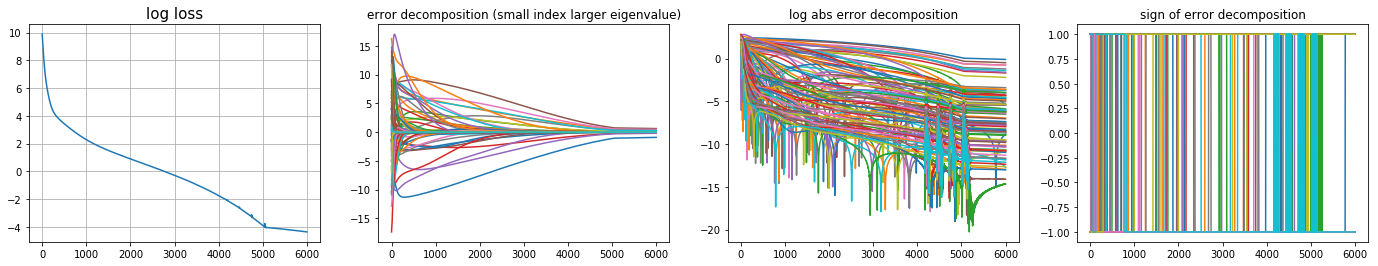

lr: 0.1 converge time: 6001 distance to solution: 1.3744498842209651


In [817]:
opt_path.max_iter = 6000 #300000
for opt in [optimizers.AdaSGD, torch.optim.SGD, torch.optim.Adam]:
    print(opt.__name__)
    if 'Adam' in opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt, schedule=[0])
    elif 'SGD' == opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=1/lambda_max, opt=opt, momentum=0.9)
    elif 'AdaSGD' == opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt, momentum=0.9, schedule=[0]) # amsgrad=True
    else:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt)
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.grid()
    plt.title('log loss', fontsize=15)
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))




#### A third way to adapt learning rate: start with low learning rate and then increase and then decrease

SGD


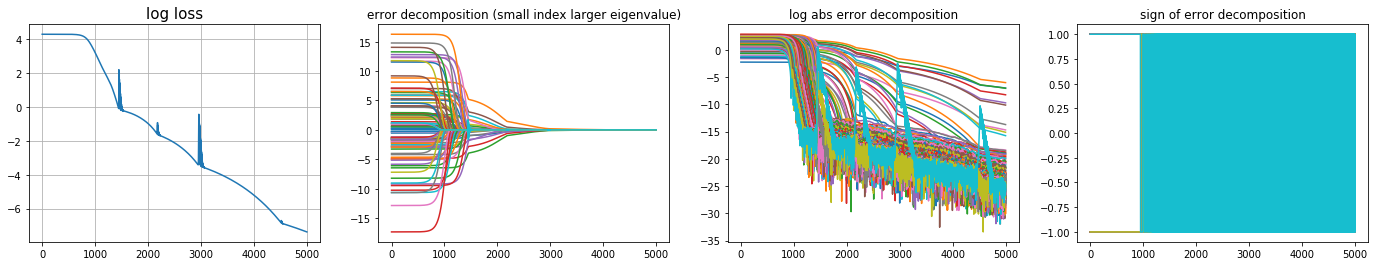

lr: 0.1 converge time: 5001 distance to solution: 0.00275074415439709


In [818]:
opt_path.max_iter = 5000 #300000
for opt in [torch.optim.SGD]:
    print(opt.__name__)
    if 'Adam' in opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt)
    elif 'SGD' == opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=1e-10, opt=opt, momentum=0.9, sgd_adjust=True)
    elif 'AdaSGD' == opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt, momentum=0.9, amsgrad=False, schedule=[0])        
    else:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt)
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log10([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.grid()
    plt.title('log loss', fontsize=15)
    #plt.xlim([900, 1100])
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))




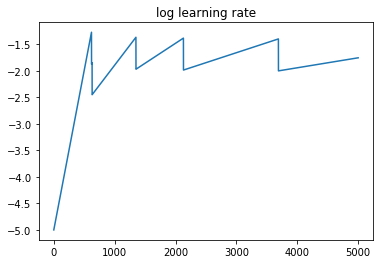

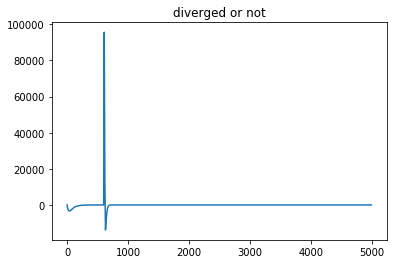

In [813]:
plt.plot(np.log10(opt_path.sgd_adjuster.lrs))
plt.title('log learning rate')
plt.show()

n = len(opt_path.sgd_adjuster.nhighers)
plt.plot(np.arange(n) * opt_path.sgd_adjuster.patience, opt_path.sgd_adjuster.nhighers)
plt.title('diverged or not')
plt.show()
#opt_path.sgd_adjuster.ls


## Transition from Adam to SGD

Since Adam adapts well to different "terrain" (curvature) of the loss surface while SGD converges to a generalizable solution (less sensitive to fragile direction), it make sense to combine these two by first running Adam and then switch to SGD. 

This new scheme thus introduces two more hyperparameters to consider: the transition time $\tau$ and the learning rate $\eta_{sgd}$ after switch. Apparently both parameters should affect the optimization path significantly. In addition to grid search for those two parameters (refered to HardSwitch in the experiments), previous work has considered soft switching (AdaBound defines a smooth transition scheme with parameter $\gamma$: $\tau \approx \gamma$), and heuristics to both determine $\tau$ and $\eta_{sgd}$ (Swats).

Before commenting on their generalization ability, we first focous on the optimization aspect. We again run simulation on the quadratic loss varying $\lambda_\max$. Our first goal is to **falsify AdaBound's claim that it is robust to settings of $\gamma$ and $\eta_{sgd}$**.

In [600]:
opt_path = OptPath(max_iter=1000, tol=1e-6)

lambda_min = 0.01 #0.001
lambda_max = 1000 #100
d = 6 # 6
x0 = np.random.uniform(2, 10, d) 
#x0 = np.array([5]*d)
criteria, Q, Lambda = gen_loss(d, lambda_min, lambda_max, logscale=True) # lambda is from small to large

gamma 0.1
AdaBound


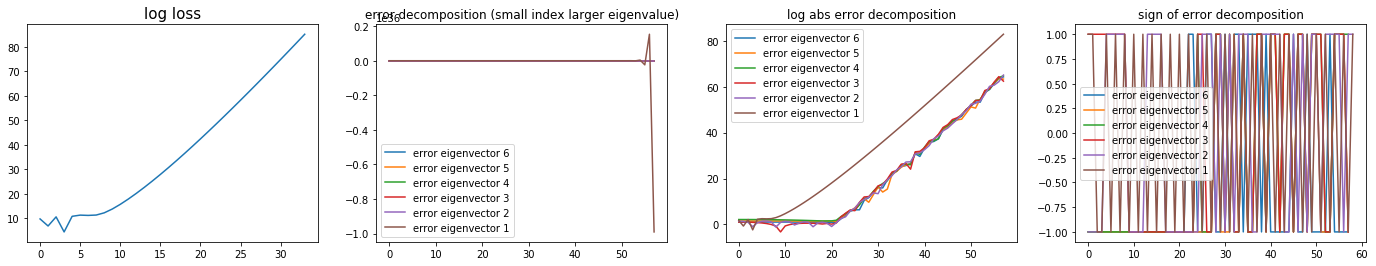

lr: 0.01 converge time: 1001 distance to solution: nan
CrossBound


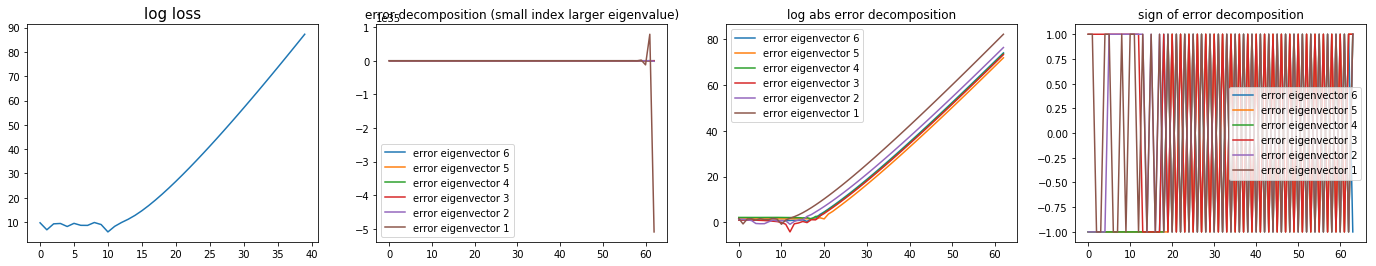

lr: 0.01 converge time: 1001 distance to solution: nan


In [610]:
print('gamma',  0.1)
opt_path.max_iter = 1000
for opt in [optimizers.AdaBound, optimizers.CrossBound]: # [optimizers.Swats, optimizers.AdaBound, optimizers.CrossBound]:
    print(opt.__name__)
    if 'Bound' in opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.001, opt=opt, gamma=0.1)
    elif 'SGD' in opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt)
    else:
        opt_path.get_path(criteria, x0, record=False, lr=0.001, opt=opt)
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.title('log loss', fontsize=15)
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))
    if opt.__name__ == 'Swats': print('Switched to SGD?:', 'yes @ iteration {}'.format(opt_path.opt.sgd_time) if opt_path.opt.SGD else 'No')




gamma=0.001
AdaBound


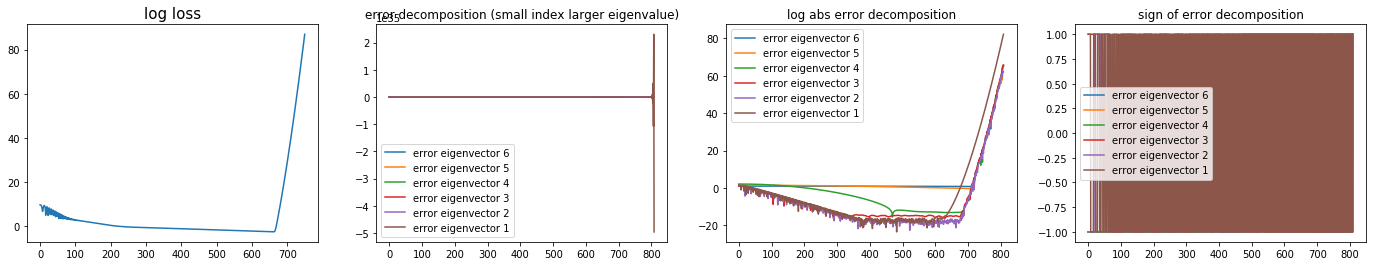

lr: 0.01 converge time: 1001 distance to solution: nan
CrossBound


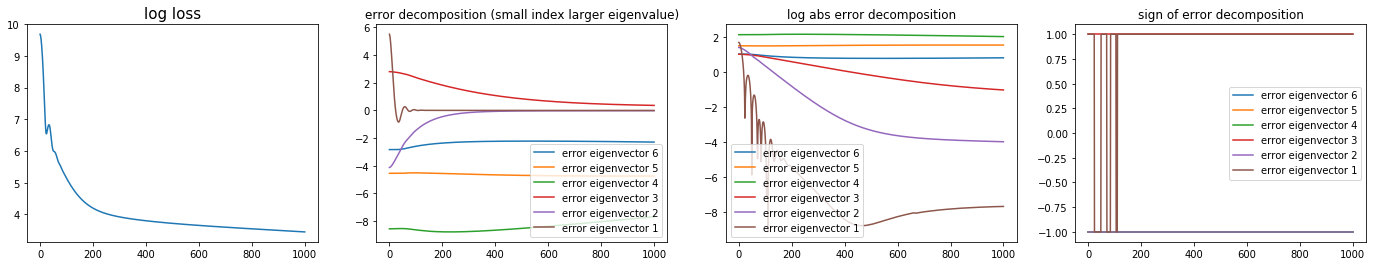

lr: 0.01 converge time: 1001 distance to solution: 9.320080890708166


In [611]:
print('gamma=0.001')
opt_path.max_iter = 1000
for opt in [optimizers.AdaBound, optimizers.CrossBound]:
    print(opt.__name__)
    if 'Bound' in opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.001, opt=opt)
    elif 'SGD' in opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt)
    else:
        opt_path.get_path(criteria, x0, record=False, lr=0.001, opt=opt)
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.title('log loss', fontsize=15)
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))
    if opt.__name__ == 'Swats': print('Switched to SGD?:', 'yes @ iteration {}'.format(opt_path.opt.sgd_time) if opt_path.opt.SGD else 'No')



Obviously, on synthetic dataset we can easily make AdaBound based method diverge, just sooner or later (larger $\gamma$ means sooner). 

Swats


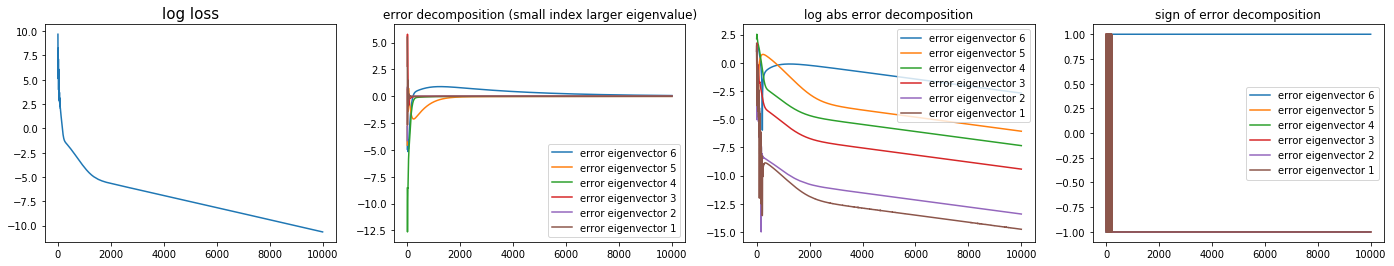

lr: 1 converge time: 10001 distance to solution: 0.06802748104353204
Switched to SGD?: No


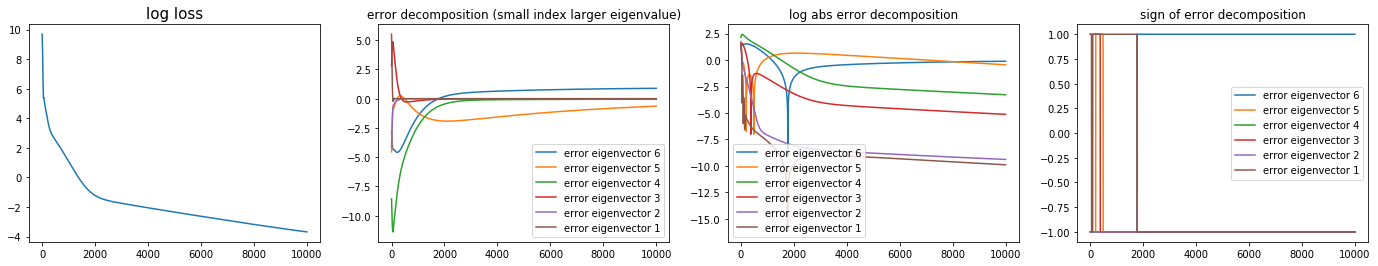

lr: 0.1 converge time: 10001 distance to solution: 1.0947681196632062
Switched to SGD?: No


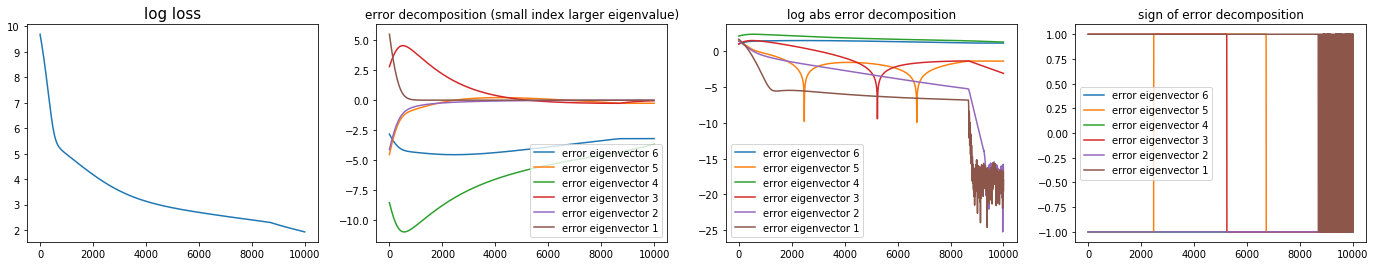

lr: 0.01 converge time: 10001 distance to solution: 4.900550649528761
Switched to SGD?: yes @ iteration 8676


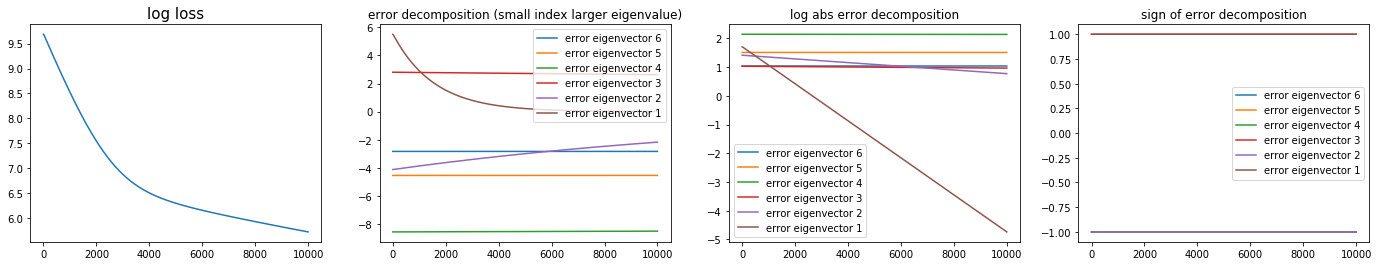

lr: 0.001 converge time: 10001 distance to solution: 10.609620439954185
Switched to SGD?: yes @ iteration 2


In [619]:
opt_path.max_iter = 10000
opt = optimizers.Swats
print(opt.__name__)
for lr in [1, 0.1, 0.01, 0.001]:
    opt_path.get_path(criteria, x0, record=False, lr=lr, opt=opt, amsgrad=True)
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.title('log loss', fontsize=15)
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
    plt.legend()
    plt.title('sign of error decomposition')
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))
    if opt.__name__ == 'Swats': print('Switched to SGD?:', 'yes @ iteration {}'.format(opt_path.opt.sgd_time) if opt_path.opt.SGD else 'No')



For Swats, whether it will change to SGD depends a lot on the initial learning rate $\eta$.

## More fun with explicit regularization

Adam's inablity to generalize better than SGD source from its lack of capacity control. In this work, we focus on weight decay and transitioning from Adam to SGD as means of controlling model complexity and examine if they really close the generalization gap and if so, how difficult it is to tune. 

![Adam_wd_train](figures/weight_decay_adam_train.png)
![Adam_wd_test](figures/weight_decay_adam_test.png)

# Paper plot

In [980]:
# lambda_max vs. kappa plot
import glob
import pandas as pd
from sklearn.externals import joblib

def get_record(savedirs=['result:0.1', 'result:0.01', 'result:0.001', 'result:1'], ):
    record = {'k': [], 'lambda_max': [], 'run_number': [], 'name': [], 'last_loss': [], 'lr': []}

    for folder in savedirs:
        for fn in tqdm.tqdm(glob.glob('synthetic_exp/{}/*'.format(folder))):
            name, k, lambda_max, run_number = list(map(lambda x: x[0](x[1]), zip([str, int, int, int], 
                                                                                 fn.split('/')[-1].split(':'))))
            record['name'].append(name)
            record['k'].append(k)
            record['lambda_max'].append(lambda_max)
            record['run_number'].append(run_number)
            f = joblib.load(fn)
            record['last_loss'].append(f['loss'][-1])
            record['lr'].append(f['lr'])
    return record

record = get_record()




















  0%|          | 0/3750 [00:00<?, ?it/s]


















  1%|          | 33/3750 [00:00<00:11, 328.75it/s]


















  2%|▏         | 66/3750 [00:00<00:11, 328.52it/s]


















  3%|▎         | 98/3750 [00:00<00:11, 325.55it/s]


















  3%|▎         | 130/3750 [00:00<00:11, 322.94it/s]


















  4%|▍         | 163/3750 [00:00<00:11, 322.76it/s]


















  5%|▌         | 196/3750 [00:00<00:11, 322.45it/s]


















  6%|▌         | 228/3750 [00:00<00:10, 320.54it/s]


















  7%|▋         | 261/3750 [00:00<00:10, 320.61it/s]


















  8%|▊         | 294/3750 [00:00<00:10, 320.52it/s]


















  9%|▊         | 326/3750 [00:01<00:10, 319.92it/s]


















 10%|▉         | 359/3750 [00:01<00:10, 321.40it/s]


















 10%|█         | 391/3750 [00:01<00:10, 315.17it/s]


















 11%|█▏        | 424/3750 [00:01<00:10, 316.66it/s]


















 12%|█▏        

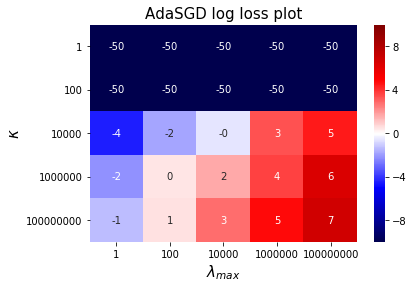

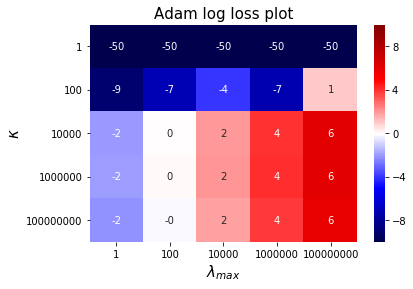

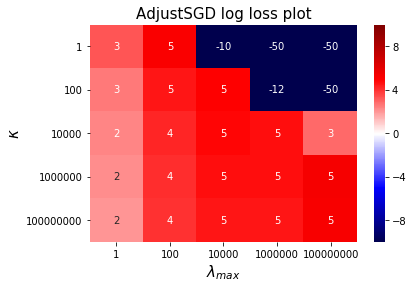

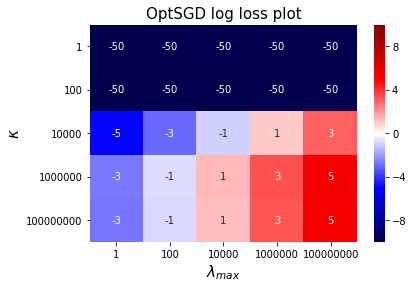

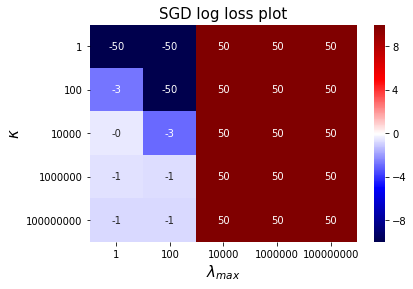

In [993]:
def generate_condition(df, lr):
    unwanted_lrs = set(np.unique(df.lr)) - set({lr})
    condition_lr = None
    for lr in unwanted_lrs:
        if condition_lr is None:
            condition_lr = (df.lr == lr)
        else:
            condition_lr = condition_lr | (df.lr == lr)
    
    condition_adam = (df.name == 'Adam')
    condition_sgd = (df.name == 'AdaSGD')
    return df[~( (condition_adam & condition_lr) | (condition_sgd & condition_lr))]

df = pd.DataFrame(record) 
df = generate_condition(df, 0.1)
df = df.fillna(10**50)
df = df.groupby(['name', 'k', 'lambda_max'], as_index=False).mean()

for name in np.unique(df.name):
    sns.heatmap(np.log10(df[df.name==name].pivot(index='k', columns='lambda_max', values='last_loss') + 1e-50), 
                vmin=-10, vmax=10, cmap='seismic', annot=True, fmt=".0f")
    plt.title('{} log loss plot'.format(name), fontsize=15)
    plt.ylabel('$\kappa$', fontsize=15)
    plt.xlabel('$\lambda_{max}$', fontsize=15)
    #plt.savefig('figures/{}_lambda_heatmap.png'.format(name), bbox_inches='tight')
    plt.show()

![heatmap](figures/Adam_lambda_heatmap.png)
![heatmap](figures/SGD_lambda_heatmap.png)
![heatmap](figures/OptSGD_lambda_heatmap.png)
![heatmap](figures/AdaSGD_lambda_heatmap.png)
![heatmap](figures/AdjustSGD_lambda_heatmap.png)


Here we show a plot for $\eta=0.1$ for both Adam and AdaSGD. A few things to notice. First, SGD with $1/\lambda_{max}$ learning rate on average beats all methods under all settings. Second, Adam does not have an edge over AdaSGD except for the last row where AdaGrad begins to oscillate within 3000 iterations. Further, although this shows that Adam and AdaSGD can find a single learning rate that are robust to condition settings, but **it doesn't mean all learning rates are robust** (see the effect by adjusting $\eta$). Note that we replace $\log(0)$ with $-50$ and $\log(nan)$ with $50$ to avoid numerical issue.

![SGD](figures/SGD_illustration.png)

In [1393]:
def drawContour(f, name, c='k', r=(-10,10), levels=None, alpha=1):
    a, b = r
    xlist = np.linspace(a, b, 100)
    ylist = np.linspace(a, b, 100)
    X, Y = np.meshgrid(xlist, ylist)
    cp = plt.contour(X, Y, f(X, Y), levels=levels, colors=c, alpha=alpha)
    plt.clabel(cp, inline=True, fontsize=10)
    plt.title(name + ' Contour Plot', fontsize=15)
    plt.xlabel(r'$\theta_{0}$', fontsize=15)
    plt.ylabel(r'$\theta_{1}$', fontsize=15)

def Loss(criteria): 
    def loss_(X, Y):
        x = torch.from_numpy(np.vstack([X.ravel(), Y.ravel()]).T).float()
        return criteria(x).data.cpu().numpy().reshape(X.shape[0], X.shape[1])
    return loss_

def gen_quadratic_data(n, d=2, lambda_min=1, lambda_max=1, logscale=False, theta_star=None, Q=None, offset=1):
    assert n > d, "n > d otherwise ill condition for this illustrative plot"
    if Q is None:
        Q = ortho_group.rvs(d)
    U = ortho_group.rvs(n)
    if not logscale:
        Lambda = np.linspace(lambda_min, lambda_max, d)
    else:
        Lambda = np.logspace(np.log10(lambda_min), np.log10(lambda_max), d)
    Sigma = np.sqrt(Lambda)
    X = U[:, :d].dot(np.diag(Sigma)).dot(Q)
    if theta_star is None:
        theta_star = np.random.randint(5, size=(d, 1))
    #y = np.random.randn(n).reshape(-1,1)
    y = X.dot(theta_star) + offset
    return Q, Lambda, X, y
    
def gen_criteria(X, y):
    D = torch.from_numpy(X).float()
    target = torch.from_numpy(y).float()
    def res(x): # x is  axd
        error = D.mm(x.transpose(0,1)) - target # n by a
        ret = 0.5 * (error * error).sum(0) / len(X)
        #print(ret.shape, error.shape)
        return ret
    theta_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return res, theta_star

def draw_path(opt_path, s=1, color=[1,0,1], name=None):
    path = opt_path.x_path
    if name is None:
        name = opt_path.opt.__class__.__name__.split('.')[-1]
    n = len(path)
    colors = np.ones((n, 1)).dot(np.array([color + [1]]))
    colors[:,3] = np.linspace(0.1, 1, n)
    #print(colors)
    plt.scatter(path[:, 0], path[:, 1], marker='s', s=s, c=colors, label=name)

def weight_decay(X, a, y, x0):
    return np.linalg.inv(X.T.dot(X) + a * np.eye(len(X.T))).dot(X.T.dot(y) + a * x0.reshape(-1, 1))


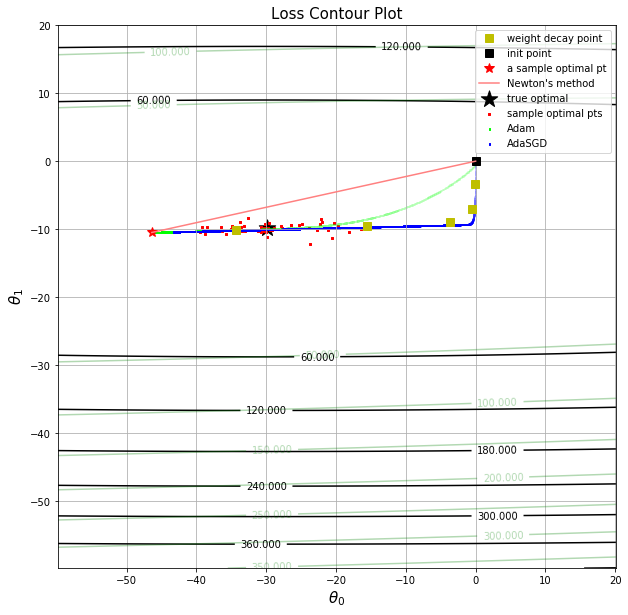

In [1397]:
plt.gcf().set_size_inches(10, 10)
n = 300
d = 2
contour_ranges = None #np.array([1, 1.25, 1.5, 2, 3, 4])
theta_star_0 = np.array([-30,-10]).reshape(-1,1)

Q = np.eye(d)
offset = 1
Q, Lambda, X, y = gen_quadratic_data(n=n, d=d, lambda_min=1, lambda_max=100, theta_star=theta_star_0, offset=offset, Q=Q)
criteria, theta_star_0 = gen_criteria(X, y)
drawContour(Loss(criteria), "Loss", levels=contour_ranges, c='k', r=(theta_star_0[0][0]-30, theta_star_0[1][0]+30))
plt.scatter([theta_star_0[0]], [theta_star_0[1]], marker='*', c='k', 
            s=300, label='true optimal')

n_runs = 50 
longest_order = None
longest_dist = 0
for i in range(n_runs):
    order = np.random.permutation(len(X))[:10]
    X_ = X[order]
    y_ = y[order]
    criteria, theta_star = gen_criteria(X_, y_)
    if i == n_runs-1:
        plt.scatter([theta_star[0]], [theta_star[1]], marker='s', s=3, c='r', label='sample optimal pts')
    else:
        plt.scatter([theta_star[0]], [theta_star[1]], marker='s', s=3, c='r')
    dist = np.linalg.norm(theta_star - theta_star_0)
    if dist > longest_dist:
        longest_dist = dist
        longest_order = copy.deepcopy(order)

X_ = X[longest_order]
y_ = y[longest_order]
criteria, theta_star = gen_criteria(X_, y_)
drawContour(Loss(criteria), "Loss", levels=contour_ranges, c='g', r=(theta_star_0[0][0]-30, theta_star_0[1][0]+30), alpha=0.3)

######### optimization begins
opt_path = OptPath(max_iter=3000)

#x0 = np.array([30, 10])
x0 = np.array([0, 0])
wds = np.logspace(np.log10(0.005), np.log10(5), 5) #[0.005, 0.01, 0.05, 0.1, 0.5]
for wd in wds:
    x_wd = weight_decay(X_, wd, y_, x0)
    if wd == wds[-1]:
        plt.plot([x_wd[0]], [x_wd[1]], "s", color='y', markersize=8, label="weight decay point")
    else:
        plt.plot([x_wd[0]], [x_wd[1]], "s", color='y', markersize=8)
        
plt.plot([x0[0]], [x0[1]], "s", color='k', markersize=8, label="init point")
plt.plot([theta_star[0]], [theta_star[1]], "*", color='r', markersize=10, label="a sample optimal pt")

opt_path.get_path(criteria, x0, lr=0.1, opt=torch.optim.Adam)
draw_path(opt_path, color=[0,1,0], s=2)

opt_path.get_path(criteria, x0, lr=0.1, opt=optimizers.AdaSGD)
draw_path(opt_path, color=[0,0,1], s=2)

# opt_path.get_path(criteria, x0, lr=10/max(Lambda), opt=torch.optim.SGD)
# draw_path(opt_path, color=[0,1,1], s=1)

# newton's method
plt.plot(np.linspace(theta_star[0], x0[0], 50), np.linspace(theta_star[1], x0[1], 50), 
         color=[1,0.5,0.5], label="Newton's method")

# main drawing
plt.grid()
leg = plt.legend(markerscale=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.savefig('figures/lsr_loss4.png')
plt.show()

![lsr_loss2](figures/lsr_loss2.png)

While the previous plot illustrates that Adam on average is not faster than SGD, this plot shows how Adam could end up on the wrong side of weight decay solution even though it is faster in this case. This synthetic dataset also shows that the smallest eigenvalue direction is affected by training data the most and could be overfitted to. We observe the same phenonmena on real dataset when perturbing the training data by 1 point. See Appendix for more detail. However, we are not saying Adam cannot learn generalizable solution. In fact, if the true solution is moved to the bottom right of the figure, then Adam is actually helpful in getting to a good solution. What we emphasize is, unlike SGD, Adam could end up in the opposite side of weight decay solution, which usually leads to overfitting.

In [ ]:
from Optimizer.lib.utils import OptPath, gen_quadratic_loss

opt_path = OptPath()
opt_path.max_iter = 6000 #300000

lambda_min = 1
lambda_max = 10**4
d = 2

thetas = np.linspace(0, 90, 10)
for theta in thetas:
    x0 = np.random.uniform(2, 10, d) 
    Q = np.array([[np.cos(theta), -np.sin(theta)], 
                  [np.sin(theta), np.cos(theta)]])
    criteria, Q, Lambda = gen_quadratic_loss(d, lambda_min, lambda_max, logscale=True, Q=Q)
    
    for opt in [optimizers.AdaSGD, torch.optim.Adam]:
        print(opt.__name__)
    if 'Adam' in opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=1, opt=opt)
    elif 'SGD' == opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=1/lambda_max, 
                          opt=opt, momentum=0.9, schedule=[0])
    elif 'AdaSGD' == opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt, momentum=0.9, amsgrad=False) # amsgrad=True
    else:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt)
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log10([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.grid()
    plt.title('log loss', fontsize=15)
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
#     error = np.array([Q.dot(x) for x in opt_path.x_path])
#     for i in range(d):
#         plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
#     #plt.legend()
#     plt.title('sign of error decomposition')
    dist = np.array([np.linalg.norm(x-x0) for x in opt_path.x_path])
    plt.plot(dist)
    plt.title('l2(w-w0)')
    #plt.savefig('figures/loss_comparison_{}_degress{}.png'.format(opt.__name__, theta))
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))




While in general Adam shows no speed up over sgd, in the special case **with aligned axis, Adam is indeed faster**, though changing the rotation angle only slightly will distroy this advantage. We illustrate this effect with the following plot, fixing $d=2$ (for $d \geq 3$ I don't really know the formula to control angle, but I can research on this later), 3000 iterations, $\kappa=10^4$ (anything blow is too easy), $\lambda_{max} = 10^4$.

In [1400]:
# lambda_max vs. kappa plot
import glob
import pandas as pd
from sklearn.externals import joblib

def get_record(savedirs=['angle_result']):
    record = {'k': [], 'lambda_max': [], 'run_number': [], 'name': [], 'last_loss': [], 'lr': [], 'angle': []}

    for folder in savedirs:
        for fn in tqdm.tqdm(glob.glob('synthetic_exp/{}/*'.format(folder))):
            name, k, lambda_max, run_number, angle = list(map(lambda x: x[0](x[1]), zip([str, int, int, int, float], 
                                                            fn.split('/')[-1].split(':'))))
            record['name'].append(name)
            record['k'].append(k)
            record['lambda_max'].append(lambda_max)
            record['run_number'].append(run_number)
            f = joblib.load(fn)
            record['last_loss'].append(f['loss'][-1])
            record['lr'].append(f['lr'])
            record['angle'].append(angle)
    return record

record = get_record()




















  0%|          | 0/1500 [00:00<?, ?it/s]


















  2%|▏         | 29/1500 [00:00<00:05, 287.30it/s]


















  4%|▍         | 59/1500 [00:00<00:04, 290.11it/s]


















  6%|▌         | 91/1500 [00:00<00:04, 298.46it/s]


















  8%|▊         | 123/1500 [00:00<00:04, 303.05it/s]


















 10%|█         | 155/1500 [00:00<00:04, 305.43it/s]


















 12%|█▏        | 187/1500 [00:00<00:04, 309.62it/s]


















 15%|█▍        | 220/1500 [00:00<00:04, 312.98it/s]


















 17%|█▋        | 253/1500 [00:00<00:03, 315.85it/s]


















 19%|█▉        | 286/1500 [00:00<00:03, 318.49it/s]


















 21%|██▏       | 319/1500 [00:01<00:03, 319.08it/s]


















 23%|██▎       | 352/1500 [00:01<00:03, 320.57it/s]


















 26%|██▌       | 385/1500 [00:01<00:03, 321.78it/s]


















 28%|██▊       | 419/1500 [00:01<00:03, 324.95it/s]


















 30%|███       

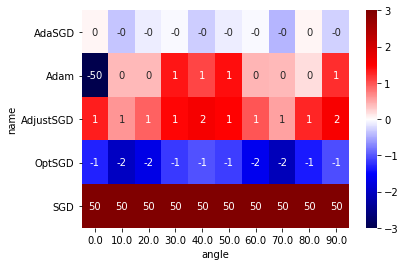

In [1416]:
df = pd.DataFrame(record) 
df = df.fillna(10**50)
df = df.groupby(['name', 'k', 'lambda_max', 'angle'], as_index=False).mean()

sns.heatmap(np.log10(df.pivot(index='name', columns='angle', values='last_loss') + 1e-50), 
            annot=True, fmt=".0f", vmin=-3, vmax=3, cmap='seismic')
plt.show()

In [1419]:
np.cos(np.pi)

-1.0

AdaSGD


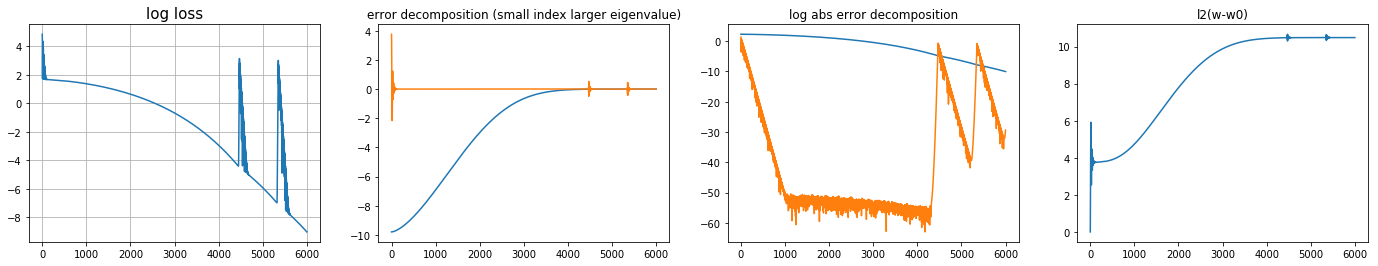

lr: 0.1 converge time: 6001 distance to solution: 4.3836451368406415e-05
Adam


/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


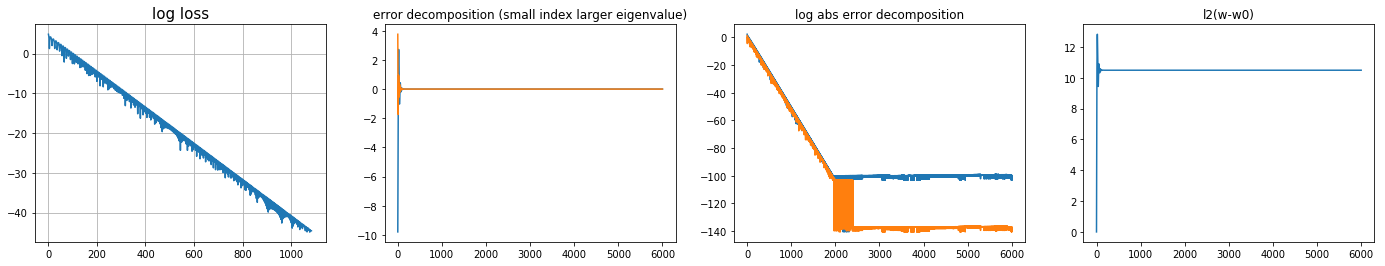

lr: 0.1 converge time: 305 distance to solution: 4.344025239406933e-44


In [1420]:
from Optimizer.lib.utils import OptPath, gen_quadratic_loss

opt_path = OptPath(max_iter=1000, tol=1e-6)

lambda_min = 1 #0.001
lambda_max = 10**4 #10**8
d = 2 # 6
x0 = np.random.uniform(2, 10, d) 
#x0 = np.array([5]*d)

theta = np.pi / 2
Q = np.array([[np.cos(theta), -np.sin(theta)], 
              [np.sin(theta), np.cos(theta)]])
criteria, Q, Lambda = gen_quadratic_loss(d, lambda_min, lambda_max, logscale=True, Q=Q)

opt_path.max_iter = 6000 #300000
for opt in [optimizers.AdaSGD, torch.optim.Adam]:
    print(opt.__name__)
    if 'Adam' in opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=1, opt=opt)
    elif 'SGD' == opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=1/lambda_max, 
                          opt=opt, momentum=0.9, schedule=[0])
    elif 'AdaSGD' == opt.__name__:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt, momentum=0.9, amsgrad=False) # amsgrad=True
    else:
        opt_path.get_path(criteria, x0, record=False, lr=0.1, opt=opt)
    plt.gcf().set_size_inches(24, 4)
    plt.subplot(1,4,1)
    plt.plot(np.log10([criteria(torch.from_numpy(x).view(1, -1).float()).item() for x in opt_path.x_path]))
    plt.grid()
    plt.title('log loss', fontsize=15)
    
    plt.subplot(1,4,2)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(error[:,i], label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('error decomposition (small index larger eigenvalue)')
    
    plt.subplot(1,4,3)
    error = np.array([Q.dot(x) for x in opt_path.x_path])
    for i in range(d):
        plt.plot(np.log(np.abs(error[:,i])), label='error eigenvector {}'.format(d-i))
    #plt.legend()
    plt.title('log abs error decomposition')

    plt.subplot(1,4,4)
#     error = np.array([Q.dot(x) for x in opt_path.x_path])
#     for i in range(d):
#         plt.plot(np.sign(error[:,i]), label='error eigenvector {}'.format(d-i))
#     #plt.legend()
#     plt.title('sign of error decomposition')
    dist = np.array([np.linalg.norm(x-x0) for x in opt_path.x_path])
    plt.plot(dist)
    plt.title('l2(w-w0)')
    #plt.savefig('figures/loss_comparison_{}_degress{}.png'.format(opt.__name__, theta))
    plt.show()
    
    print('lr: {}'.format(lr), 'converge time:', opt_path.get_converge_time(), 'distance to solution:', np.linalg.norm(opt_path.x_path[-1]))


